# Perceptual Space of Singing Voices - Analysis

In [1]:
import h5py
# from util import 
import pdb
import csv
import ast
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import itertools, os
%load_ext autoreload

## Define functions for clustering analysis

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from kneed import KneeLocator
from collections import Counter


def get_elbow_array(h5, indices, k_range, file_name, show_plot, s_param, save_plot=False):

    num_experiments = len(indices)
    elbows=np.empty(num_experiments)
    for idx_idx, idx in enumerate(indices):
        rearranged_dissim_matrix = h5['dissim_matrix'][idx]
        dissim_matrix = np.around(rearranged_dissim_matrix, 2)    
        cluster_scores = cluster_scoring(idx, dissim_matrix, k_range, show_plot=show_plot)
        kneedle = KneeLocator(k_range, cluster_scores, S=s_param, curve='convex', direction='decreasing')
    #    print('idx: ', idx,'elbow_dim: ', kneedle.elbow)
        elbows[idx_idx] = kneedle.elbow
    if show_plot:
        elbow_bar_solutions = []
        # get range between (inclusive means adding +1) min and max
        cluster_range=range(int(np.min(elbows)),int(np.max(elbows)+1))
        for entry in cluster_range:
            cluster_num = entry
            total_sum_per_cluster_num = np.count_nonzero(elbows==cluster_num)
            elbow_bar_solutions.append(total_sum_per_cluster_num)
            
        plt.bar(cluster_range, elbow_bar_solutions)
        plt.title(file_name)
        plt.xticks(k_range)
#        plt.yticks(range(0,40,2))
        plt.tight_layout()
        if save_plot:
            subdir = 'kMeans elbow bar graph'
            if not os.path.exists(subdir):
                os.mkdir(subdir)
            plt.savefig(os.path.join(subdir, file_name))
        plt.show()
        plt.close()
#        print('With S= ' +str(s_level))
    return elbows


def cluster_scoring(idx, dissim_matrix, k_range, show_plot=True, save_plot=False):

    sse_list=[]
    sse = kmeans_sse_from_arrays(k_range, dissim_matrix)
    if show_plot==True:
        fig_1 = plt.figure(1, figsize=(6.4, 4.8))
        plt.plot(k_range, sse)
#        plt.title('SSE per k number for Exp ' +str(idx))
        plt.xlabel('Dimensions for k')
        plt.ylabel('SSE loss')
        if save_plot:
            subdir = 'kMeans_SSEs_default_setting'
            if not os.path.exists(subdir):
                os.mkdir(subdir)
            plt.savefig(os.path.join(subdir, f'Participant {str(idx)}'))
        plt.show()
        plt.close()
    return sse


def kmeans_sse_from_arrays(k_range, arrays):
    sum_squared_error = []
    for k_dim in k_range:
        km = KMeans(n_clusters=k_dim)
        km.fit_predict(arrays)
        sum_squared_error.append(km.inertia_)
    return sum_squared_error


def strings_to_classes(strings_list_to_convert, substring_list):
    class_list = []
    for string in strings_list_to_convert:
        if type(string) == bytes:
            string = string.decode("utf-8")
        for class_number, substring in enumerate(substring_list):
            if type(substring) == bytes:
                substring = substring.decode("utf-8") 
            if substring in string:
                class_list.append(class_number)
                break
    return class_list


def get_silhouette_accuracy(dataset, cluster_algorithm, num_clusters, class_list, score_type):
    """
        Gets the sillhouette and accuracy score for a clustering label predictions on a given dataset
    """
    if cluster_algorithm == 'kmeans':
        cluster_model = KMeans(n_clusters=num_clusters)
    elif cluster_algorithm == 'agglomerative':
        cluster_model = AgglomerativeClustering(n_clusters=num_clusters, affinity = 'euclidean', linkage='ward')
    
    cluster_group_predictions = cluster_model.fit_predict(dataset) 
    if score_type == 'silhouette':
        score = silhouette_score(dataset, cluster_group_predictions, metric='euclidean')
    elif score_type == 'accuracy':
        score = adjusted_rand_score(cluster_group_predictions, class_list)
    else:
        raise NotImplementedError
    
    return score


def find_best_k_values(h5, indices, condition_name, k, cluster_algorithm, score_type, show_plot=True, save_plot=False):

    if type(k) == range:
        
        if cluster_algorithm == 'kmeans': k_offset = 2   
        elif cluster_algorithm == 'agglomerative': k_offset = 2
        k_range = k
    elif type(k) == int:
        k_range = range(k, k+1)
        k_offset = k
    else: raise NotImplementedError

    label_list = ['straight', 'belt', 'breathy', 'fry', 'vibrato']
    best_k_from_scores = []
    scores_for_all_ks = np.zeros( (len(indices), len(k_range)) )

    # go through each participant dataset
    for idx_idx, idx in enumerate(indices):

        scores = []
        rearranged_dissim_matrix = h5['dissim_matrix'][idx]
        rearranged_ref_audio = h5['rearrangedReferenceAudioNames'][idx]
        rearranged_class_list = strings_to_classes(rearranged_ref_audio, label_list)


#         pdb.set_trace()
        for num_clusters in k_range:

            score = get_silhouette_accuracy(rearranged_dissim_matrix,
                                            cluster_algorithm,
                                            num_clusters,
                                            rearranged_class_list,
                                            score_type)
            scores.append(score)

        scores = np.asarray(scores)
        scores_for_all_ks[idx_idx, ...] = scores
        best_k_from_scores.append(np.argmax(scores)+k_offset)

    # Use Counter to count the occurrences of each element
    counter = Counter(best_k_from_scores)

    # Find the most common element and its count
    most_common_element = counter.most_common(1)[0][0]
    scores_using_best_k = scores_for_all_ks[:, most_common_element-k_offset]
    
    # print bar graphs of best k scores
    if show_plot:
        # turn best_k_from_silhouettes into bar graph suitable data
        # os.makedirs(f'{cluster_algorithm}_{score_type}_distributions/', exist_ok=True)
        file_name = f'{cluster_algorithm}_{score_type}_distributions'
        best_k_hist = []
        cluster_solution_range = range(int(np.min(best_k_from_scores)),int(np.max(best_k_from_scores)+1))
        for cluster_num in cluster_solution_range:
            total_sum_per_cluster_num = np.count_nonzero(np.asarray(best_k_from_scores)==cluster_num)
            best_k_hist.append(total_sum_per_cluster_num)
            
        plt.bar(cluster_solution_range, best_k_hist)
        plt.title(f'{condition_name}_{cluster_algorithm}_{score_type}_distributions')
        plt.xticks(k_range)
        plt.xlabel('Dimensions for k')
        plt.tight_layout()
        if save_plot:
            subdir = 'k_silhouettes_distributions'
            if not os.path.exists(subdir):
                os.mkdir(subdir)
            plt.savefig(os.path.join(subdir, file_name))
        plt.show()
        plt.close()

    return scores_using_best_k, best_k_from_scores

## Define functions for correlation analysis

In [46]:
from scipy.stats import pearsonr, kendalltau, spearmanr

def diagonal_array_handling(diagonal_arrays):
    """Takes list of 'list of strings', converts strings to floats, sums floats, return list of summed floats"""
    return [sum(ast.literal_eval(da.decode('utf-8'))) for da in diagonal_arrays]

def array_column_correlations(array, feat_names, sig_thresh, test_type, show_plot=True):
    """
    Finds correlations between different features provided by participants,
    which include their questionnaire information and rating clustering metrics.
    
    """
    
    def get_array_feats(idx, array, feat_names):
        """Extract features from array at index, while allowing for specific
        processing if the index calls on the identity recognition features"""

        feats_name = feat_names[idx]
        feats = array[:,idx]
        if idx == 5:
            feats = diagonal_array_handling(feats)
        
        feats = np.asarray(feats).astype(float)
            
        return feats_name, feats
    
    
    # setup variables
    num_feats = array.shape[1]
    correlation_dict = {}
    correlation_list = []
    
    # tests every collection of values against every other collection of values for correlation
    for i in range(0, num_feats):

        for j in range(0, num_feats):
            
            if i == j: continue
            
            i_feats_name, i_feats = get_array_feats(i, array, feat_names)
            j_feats_name, j_feats = get_array_feats(j, array, feat_names)
                
            if test_type=='pearsonr':
                r_val, p_val = pearsonr(i_feats, j_feats)
            elif test_type=='kendalltau':
                r_val, p_val = kendalltau(i_feats, j_feats)
            elif test_type=='spearmanr':
                r_val, p_val = spearmanr(i_feats, j_feats)
#             print(f'corr: {i_feats_name} x {j_feats_name}:', r_val, p_val)
                
            # add result to list if p_val is low enough and conditions haven't been compared
            if p_val <= sig_thresh:
                
                # check to see if this feature comparison was already recorded in dict
                if f'{i_feats_name} x {j_feats_name}' in correlation_dict.keys():
                    continue
                elif f'{j_feats_name} x {i_feats_name}' in correlation_dict.keys():
                    continue
                    
                else:
                    entry = (i_feats_name, j_feats_name, r_val, p_val)
                    correlation_dict[f'{i_feats_name} x {j_feats_name}'] = entry
                    correlation_list.append(entry)
                    print(entry)
                    
                    if show_plot:
#                         pdb.set_trace()
                        y_min = np.min(j_feats)
                        y_max = np.max(j_feats)
                        y_interval = round((y_max-y_min)/10, 2)  # Set the desired interval
                        plt.yticks(np.arange(y_min, y_max, y_interval))
                        plt.scatter(i_feats, j_feats)
                        plt.ylabel(j_feats_name)
                        plt.xlabel(i_feats_name)
                        plt.show()
                        plt.close()
                                        
    return correlation_dict, correlation_list

## Define functions for generating pairwise distance distributions across all classes, and lists of ratings

In [4]:
def collect_ratings(rearranged_dissim_matrix, rearranged_class_list, class_pair):
    
    """
    Collects dissim ratings relating to the given class pair.
    The order of the class pair is important to dismiss reordered version being collected
    from the similarity matrix.
    
    If there are 3 versions of each class, this would return 9 ratings
    If there were 3 of one class and 2 of another, only 6 ratings would be returned
    """

    # find element in dissimilarity matrix for given experiment entry
    ref_class, comp_class = class_pair
    class_pair_comparisons = []
#     pdb.set_trace()
    for class_idx_row, class_val_row in enumerate(rearranged_class_list):
        if class_val_row == ref_class:
#             print('class_val_row', class_val_row)
            matrix_row_val = class_idx_row
            for class_idx_col, class_val_col in enumerate(rearranged_class_list):
                if class_val_col == comp_class:
#                     print('class_val_col', class_val_col)
                    matrix_col_val = class_idx_col
                    comparison = rearranged_dissim_matrix[matrix_row_val,matrix_col_val]
                    class_pair_comparisons.append(comparison)

    return class_pair_comparisons



# these rating lists are grouped by pairwise comparisons (of which there are 15 conditions)
def class_rating_distributions(h5_ram, parent_list, class_pairs, id_string_list,
                               directory_name, show_plot=True, print_monitor=False, label_list=None, save_plot=False):
    
    """
    Get flattened list of all ratings for given list of experiment indices,
    (usually pertaining to a condition group).
    Optionally print these out.

    Return a list nested by the following structure:
        Class ratings -> condition group -> session ratings -> individual ratings
    
    """
    
    
    if label_list == None:
        label_list = ['straight', 'belt', 'breathy', 'fry', 'vibrato']
    all_class_distances_all_lists = []
    
    # iterate through class pair conditions
    for class_pair in class_pairs:
        specific_class_all_lists = []
        
        # iterate through each session in given parent list, and collect class_pair dissimilarity ratings
        for parent_idx, condition_list in enumerate(parent_list):
            condition_list_distances = []
            if print_monitor:
                print('condition_idx', parent_idx)
            
            # go through each experiemnt index
            for experiment_idx in condition_list:
                
                # get order of class names for this experiment entry
                rearranged_dissim_matrix = h5_ram['dissim_matrix'][experiment_idx]
                rearranged_ref_audio = h5_ram['rearrangedReferenceAudioNames'][experiment_idx]
                rearranged_class_list = strings_to_classes(rearranged_ref_audio, label_list)
                
                class_pair_comparisons = collect_ratings(rearranged_dissim_matrix,
                                                         rearranged_class_list, class_pair)
                if print_monitor:
                    print(experiment_idx, 'class_pair_comparisons:', class_pair_comparisons)
                
                # nest given dissim rating in parent list
                condition_list_distances.append(class_pair_comparisons)
                try:
                    os.makedirs(directory_name +'/' +id_string_list[parent_idx], exist_ok=True)
                except:
                    pdb.set_trace()

            specific_class_all_lists.append(condition_list_distances)
            flattened_distances = [rating for cond_list in condition_list_distances for rating in cond_list]
            
            # PLOT AND SAVE HISTOGRAM
            if show_plot==True:
                plt.hist(flattened_distances, bins=10)
                title ='class {0} to {1} ratings'.format(class_pair[0], class_pair[1])
                plt.title(title)
                plt.tight_layout()
                if save_plot:
                    plt.savefig(directory_name +'/' +id_string_list[parent_idx] +'/' +title)
                plt.show()
                plt.close()
            
        all_class_distances_all_lists.append(specific_class_all_lists)
    
    all_class_distances_all_lists = np.asarray(all_class_distances_all_lists)
    np.save(directory_name +'/' +directory_name, all_class_distances_all_lists)
    
    return all_class_distances_all_lists

### Other function definitions

In [5]:
from sklearn.manifold import MDS
import random

def display_dissim_heatmaps(dissim_matrix, ref_audio_names, idx, save_plot=False):
    label_list = ['straight', 'belt', 'breathy', 'fry', 'vibrato']
    shortened_ref_list = []
    for label_idx, label in enumerate(label_list):
        for ref_ind, referenceAudioName in enumerate(ref_audio_names):  
            if label in referenceAudioName.decode('utf-8'):
                shortened_ref_list.append(label_list[label_idx][:3])
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(dissim_matrix)
    ax.set_xticks(np.arange(len(ref_audio_names)))
    ax.set_yticks(np.arange(len(ref_audio_names)))
    ax.set_xticklabels(shortened_ref_list)
    ax.set_yticklabels(shortened_ref_list)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    # WRITE NUMBERS INTO CELLS
    for i in range(len(ref_audio_names)):
        for j in range(len(ref_audio_names)):
            text = ax.text(j, i, dissim_matrix[i, j],
                           ha="center", va="center", color="w")
    title=f"Dissimilarity Matrix of Participant {idx}"
    ax.set_title(title)
    fig.tight_layout()
    if save_plot:
        dir_name = 'dissim_matrices'
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        plt.savefig(os.path.join(dir_name, title))
    plt.show()
    plt.close()
    return


def list_to_csvfile(list_of_rows, fp):
    with open(fp, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(list_of_rows)
        

def indices_by_key_value(h5, key_ref, idx, value):
    # collect all sessions with target session name
    idx_list=[]
    num_experiments = len(h5[key_ref])
    for experiment_idx in range(num_experiments):
        session_name = h5[key_ref][experiment_idx][idx]
        if type(session_name) == bytes:
            session_name = session_name.decode("utf-8")
        if type(value) == bytes:
            value = value.decode("utf-8")
        if value in session_name:
            idx_list.append(experiment_idx)    

    return idx_list


def mds_from_dissim_matrix(dissim_matrix, ref_list, dimensions, show_plot=True, title='mds_plot',save_plot=False):
    np.random.seed(19680801)
#    label_list = ['straight', 'belt', 'breathy', 'fry', 'vibrato']
    label_dict = {'straight':0, 'belt':1, 'breathy':2, 'fry':3, 'vibrato':4}
    color_list = ['r', 'g', 'b', 'c', 'm']

#    print(dissim_matrix.shape)
    embedding = MDS(n_components=dimensions, metric=False, dissimilarity='precomputed')
    exp_transfomed = embedding.fit_transform(dissim_matrix)
#    print(exp_transfomed.shape)
    if show_plot==True:
        
        fig = plt.figure()
        if dimensions==3:
            ax = fig.add_subplot(111, projection='3d')
        else:
            ax = fig.add_subplot(111)
        # match labels to ref_list to assign colours to scatter plot points
        for label_int, label in enumerate(label_dict):
            for ref_ind, referenceAudioName in enumerate(ref_list):  
                if label in referenceAudioName:
                    label_colour = color_list[label_int]
                    if dimensions==3:
                        ax.scatter(exp_transfomed[ref_ind, 0], exp_transfomed[ref_ind, 1], exp_transfomed[ref_ind, 2], c=label_colour, label=label)
                    else:
                        ax.scatter(exp_transfomed[ref_ind, 0], exp_transfomed[ref_ind, 1], c=label_colour, label=label)
                        
        plt.xlim(-0.8,0.8)
        plt.ylim((-0.7,0.7))
        plt.title(title)
        plt.legend(label_dict)
        if save_plot:
            dir_name = 'mds_plots'
            if not os.path.exists(dir_name):
                os.mkdir(dir_name)
            plt.savefig(os.path.join(dir_name, title))
        plt.show()
        plt.close()
    return exp_transfomed

In [6]:
# FUNCTIONS THAT ARE NO LONGER NEEDED

# def make_label_counter():
#     label_count = {}
#     for label in label_list:
#         label_count[label] = 0
#     return label_count

# # find out which singing techniques are under-represented in each example 
# def lowest_label_counts(parent_list):
    
#     lowest_label_count = make_label_counter()
    
#     for i in parent_list:

#         qwe = h5_ram['rearrangedReferenceAudioNames'][i]

#         label_count = make_label_counter()

#         # count labels in each example
#         for audioname in qwe:

#             for label in label_count.keys():
                
#                 if label in audioname.decode("utf-8"):

#                     label_count[label] += 1

#         min_val = 100

#         # find singing technique with least examples present and store
#         for label in label_count.keys():

#             if label_count[label] >3:
#                 pdb.set_trace()
#                 raise NotImplementedError("This dataset has two many entries for one class")

#             if label_count[label] < min_val:

#                 min_val = label_count[label]
#                 min_label = label

#         print((min_label, min_val))
#         assert min_val == 2
#         lowest_label_count[min_label] += 1
        
#     return lowest_label_count

## Load h5 file, make a copy of it in ram to analyze

In [7]:
run_once=True #this variable will be changed later to ensure certain cells can't be run again

In [8]:
h5_path = "anon_perceptual_dissimilarity_data.hdf5"

if 'h5' in globals():
    h5.close()

h5 = h5py.File(h5_path, mode = 'r+')

In [9]:
h5_ram = {}
for key in h5.keys():
    h5_ram[key] = h5[key][...]

In [10]:
h5_ram['participant_info'][0]

array([b'ugjSfy36X9lnPrsvVS6qeYQ3L9pfr4fX', b'f3highPitch', b'4:6:2020',
       b'22:5:31', b'', b'1', b'5', b'25', b'f', b'5', b'5', b'5', b'5',
       b'3', b'4', b'4', b'2', b'6', b'None', b'', b'1',
       b'838.7221768707489', b'6', b'63.492063492063494', b'0', b'1',
       b'[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]',
       b'0.3539420856580918',
       b'f3_scales_vocal_fry_u_highPitch_2.4613-3.4613s.mp3'],
      dtype=object)

### The 'participant_info' key of the h5_ram file contains the following information about the participant:
0. Their corresponding Xml file name (not publically available)
1. The session set they were given to evaluate
2. The date and 
3. time they participated
4. Email address (not publically available)
5. Listening Equipment (1-inbuilt speakers, 2-external speaker, 3-ear/headphones)
6. Listening Environment (1(very noisy) - 5 (very quiet))
7. Age
8. Gender
9. Gold-MSI 'Perceptual Abilities' Question 1 - see Mullensiefen (2014) for response types
10. Gold-MSI 'Perceptual Abilities' Question 2 - see Mullensiefen (2014) for response types
11. Gold-MSI 'Perceptual Abilities' Question 3 - see Mullensiefen (2014) for response types
12. Gold-MSI 'Perceptual Abilities' Question 4 - see Mullensiefen (2014) for response types
13. Gold-MSI 'Perceptual Abilities' Question 5 - see Mullensiefen (2014) for response types
14. Gold-MSI 'Perceptual Abilities' Question 6 - see Mullensiefen (2014) for response types
15. Gold-MSI 'Perceptual Abilities' Question 7 - see Mullensiefen (2014) for response types
16. Gold-MSI 'Perceptual Abilities' Question 8 - see Mullensiefen (2014) for response types
17. Gold-MSI 'Perceptual Abilities' Question 9 - see Mullensiefen (2014) for response types
18. Instrument (post-annotated with categorical information n=None, s=singer, other=musician)
19. Feedback (post-annotated with ordinal data 1-4 to reflect level of comprehension (5=not annotated))
20. Self-reported Impairments (1=no, 2=yes, 3=minor)
21. Time taken to complete study
22. Listening ability - Listening Equipment + Listening Environment
23. Total MSI-score
24. Ordinal Musician (derived from categorical post-annotated data from 18)
25. Task Comprehension (derived from ordinal post-annotated data from 19)
26. Reliability by self-similarity identification, reliability by repeated pages
27. Consistency (sum of squared errors between two identical test pages)
28. Neglected audio file (due to data collection error, ratings related to one particular audio file in each set were lost)

## Detect unreliable participant data using three methods

In [11]:
"""remove those with worst task comp scores (0)"""

comp_score_thresh = 0
unsatisfactory_part_indices = set()
for idx in range(len(h5_ram['participant_info'])):
    comp_score = h5_ram['participant_info'][idx][25]
#     pdb.set_trace()
    if int(comp_score) == comp_score_thresh:
        print('comprehension failed idx: ', idx)
        unsatisfactory_part_indices.add(idx)

"""remove those that could not identify same-audio clips within reason"""

same_audio_sim_threshold = 0.1
same_audio_sim_fail_thresh = 2
for idx in range(len(h5_ram['participant_info'])):
    diagonal_vals = h5_ram['participant_info'][idx][26]
#     print(diagonal_vals)
    num_cells_above_threshold = len([val for val in ast.literal_eval(diagonal_vals.decode("utf-8")) if val > same_audio_sim_threshold])
#     print(num_cells_above_threshold)
    if num_cells_above_threshold > same_audio_sim_fail_thresh:
        print('same-audio indentification failed idx: ', idx)
        unsatisfactory_part_indices.add(idx)


"""remove those that yielded higher rmse scores between repeated pages"""

rmse_thresh = 0.4
for idx in range(len(h5_ram['participant_info'])):
    rmse = h5_ram['participant_info'][idx][27]
    if float(rmse) > rmse_thresh:
        print('rmse failed idx: ', idx)
        unsatisfactory_part_indices.add(idx)
        

comprehension failed idx:  13
comprehension failed idx:  18
comprehension failed idx:  33
same-audio indentification failed idx:  51
same-audio indentification failed idx:  52
rmse failed idx:  10
rmse failed idx:  51


### Remove unrelaible entries from h5_ram dataset (only run this cell once)

In [12]:
if run_once:
    print(len(h5_ram['participantRatings']))

    for key in h5_ram.keys():
        all_entries = h5_ram[key]
        num_entries = all_entries.shape[0]
        mask = np.ones(num_entries, dtype=bool)
        mask[list(unsatisfactory_part_indices)] = False
        filtered_entries = np.asarray(all_entries)[mask, ...]
        h5_ram[key] = filtered_entries

    for key in h5_ram.keys():
        print(h5_ram[key].shape)

    num_experiments = len(h5_ram['participantRatings'])
    num_experiments
else:
    raise Exception('Error. Do not run this cell a second time without restarting the kernel')
    
run_once = False

61
(55, 14, 8)
(55, 14, 14)
(55, 15, 15)
(55, 14, 2)
(55, 14, 3)
(55, 14, 3)
(55, 14, 8)
(55, 29)
(55, 14)
(55, 14)
(55, 2, 8)
(55, 2, 8)
(55, 2)
(55, 14, 14)


### Declare list variables

In [13]:
# Make this variable false to avoid displaying graphs
save_plot = False

session_names = ['m1low','m2low','m4low','m1high','m2high','m4high',
                 'f2low','f3low','f5low','f2high','f3high','f5high']
singer_names = ['m1','m2','m4','f2','f3','f5']
register_cond_names = ['lows','highs']
gender_cond_names = ['male','female']

label_list = ['straight','belt','breathy','fry','vibrato']
label_class_dict = {'straight':0,'belt':1,'breathy':2,'fry':3,'vibrato':4}
class_pairs = list(itertools.combinations(label_class_dict.values(), 2))
class_pairs.extend(((0,0), (1,1), (2,2), (3,3), (4,4)))
class_pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4),
 (0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4)]

## Create lists of indices based on condition groups

In [14]:
# Collect participant indices for each condition and each group in lists (first 4 are lists, next 4 are arrays)

indices_for_low_sessions = indices_by_key_value(h5_ram, 'participant_info', 1, 'low')
indices_for_high_sessions = indices_by_key_value(h5_ram, 'participant_info', 1, 'high')
indices_for_male_sessions = indices_by_key_value(h5_ram, 'participant_info', 1, 'm')
indices_for_female_sessions = indices_by_key_value(h5_ram, 'participant_info', 1, 'f')

indices_for_low_male_session = np.setdiff1d(indices_for_male_sessions, indices_for_high_sessions)
indices_for_high_male_session = np.setdiff1d(indices_for_male_sessions, indices_for_low_sessions)
indices_for_low_female_session = np.setdiff1d(indices_for_female_sessions, indices_for_high_sessions)
indices_for_high_female_session = np.setdiff1d(indices_for_female_sessions, indices_for_low_sessions)

In [15]:
# Combine index lists for same variable types (all lists)

indices_grouped_by_session = []
for session in session_names:
    indices_for_specific_session = indices_by_key_value(h5_ram, 'participant_info', 1, session)
    indices_grouped_by_session.append(indices_for_specific_session)

    
indices_grouped_by_singer = []
for singer in singer_names:
    indices_for_specific_singer = indices_by_key_value(h5_ram, 'participant_info', 1, singer)
    indices_grouped_by_singer.append(indices_for_specific_singer)
    
indices_grouped_by_register = [indices_for_low_sessions, indices_for_high_sessions]
indices_grouped_by_gender = [indices_for_male_sessions, indices_for_female_sessions]


indices_grouped_by_condition_groups = [indices_grouped_by_session, indices_grouped_by_singer,
                                         indices_grouped_by_register, indices_grouped_by_gender]

indices_grouped_individually = [[i] for i in range(60)]

# Generate Distributions

In [16]:
print_monitor=False
intra_session_ratings = class_rating_distributions(h5_ram, indices_grouped_by_session,
                                                   class_pairs, session_names, 'intra_session_distributions',
                                                   show_plot=False, print_monitor=print_monitor)
intra_singer_ratings = class_rating_distributions(h5_ram, indices_grouped_by_singer,
                                                  class_pairs, singer_names, 'intra_singer_distributions',
                                                   show_plot=False, print_monitor=print_monitor)
intra_register_ratings = class_rating_distributions(h5_ram, indices_grouped_by_register,
                                                    class_pairs, register_cond_names, 'intra_register_distributions',
                                                   show_plot=False, print_monitor=print_monitor)
intra_gender_ratings = class_rating_distributions(h5_ram, indices_grouped_by_gender,
                                                  class_pairs, gender_cond_names, 'intra_gender_distributions',
                                                   show_plot=False, print_monitor=print_monitor)

/Users/brendanoconnor/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [17]:
rating_groups = [intra_session_ratings,
                 intra_singer_ratings,
                 intra_register_ratings,
                 intra_gender_ratings]

group_names = ['intra_session_ratings',
                 'intra_singer_ratings',
                 'intra_register_ratings',
                 'intra_gender_ratings']

condition_names = [session_names,
                   singer_names,
                   register_cond_names,
                   gender_cond_names]

### Intra-condition ratings contain all ratings for a given condition. However, the final grouping of these ratings is based on class pairs. So the first entry for these lists will relate to class pair (0,1), the second to (0,2) etc.

In [18]:
print('num class pairs:', len(intra_session_ratings))
print('num conditions (sessions, gender or singer):', len(intra_session_ratings[0]))
print('num relevant experiments for each condition:', len(intra_session_ratings[0][0]))
print('num class_pair ratings per experiment:', len(intra_session_ratings[0][0][0]))

num class pairs: 15
num conditions (sessions, gender or singer): 12
num relevant experiments for each condition: 6
num class_pair ratings per experiment: 6


### Plot distribution of ratings per participant to show how frequently they used certain ratings - only useful for analyzing indivuals behaviour

In [19]:
square_matrix_dim = len(h5_ram['dissim_matrix'][0])
flattened_participant_ratings_list = []
directory_name = 'participant_rating_distributions'
for experiment_idx in range(num_experiments):
    dissim_matrix = h5_ram['dissim_matrix'][experiment_idx]
    flattened_dissim_matrix = dissim_matrix.flatten()
    flattened_participant_ratings_list.append(flattened_dissim_matrix)
    if False:
        plt.hist(flattened_dissim_matrix, bins=15)
        os.makedirs(directory_name, exist_ok=True)
        title ='Experiment_idx {0} ratings'.format(experiment_idx)
        plt.title(title)
        plt.tight_layout()
        if save_plot:
            plt.savefig(directory_name +'/' +'Experiment_idx {0} ratings'.format(experiment_idx))
        plt.show()
        plt.close()

### Example of some dissimilarity ratings

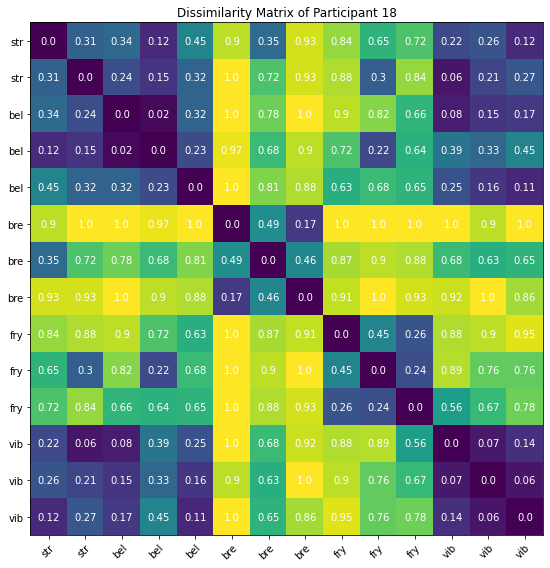

In [20]:
random_ints = [random.randint(0, num_experiments) for _ in range(1)]
random_ints = [18]
for r_idx in random_ints:
    dissim_matrix = h5_ram['dissim_matrix'][r_idx]
    ref_auds = h5_ram['referenceAudioNames'][r_idx]
    display_dissim_heatmaps(dissim_matrix, ref_auds, r_idx, save_plot=True)

### Plot Distribution For Ratings Across All Participants - purely out of interest not analytical use

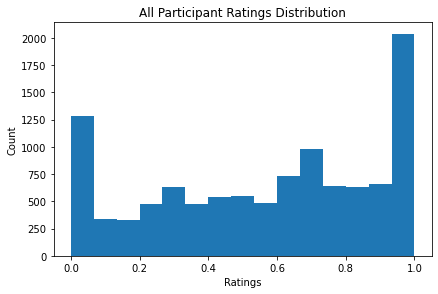

In [21]:
# histogram representation used to represent continous data distribution
flattened_flattened_participant_ratings_list = [rating
                                                for participant in flattened_participant_ratings_list
                                                for rating in participant]
plt.hist(flattened_flattened_participant_ratings_list, bins=15)
os.makedirs(directory_name, exist_ok=True)
title ='All Participant Ratings Distribution'
plt.title(title)
plt.tight_layout()
plt.xlabel('Ratings')
plt.ylabel('Count')
if save_plot:
    plt.savefig(directory_name +'/' +'All Participant Ratings')
plt.show()
plt.close()

## Generate a profile array of features containing participant information that has been converted to ordinal data

In [22]:
# Go through participant's info and add relevant data to profile_array
total_features = 7
profile_array = np.empty((0,total_features))

profile_label_names = ['Hearing Impairments',
                 'Listen Ability',
                 'Musician Category',
                 'MSI score',
                 'Task Comprehension Level',
                 'Identity Recognition',
                 'Poor Repetition'
                ]

profile_label_dict = {'Hearing Impairments':('Hearing Impairments',('None','Not significant')),
                 'Listen Ability':('Score',('4','5','6','7','8')),
                 'Musician Category':('Musical Category',('Non-musician','Musician','Singer')),
                 'MSI score':('Score',()),
                 'Task Comprehension Level':('Task Comprehension Level',('1','2','3','4','5')),
                 'Identity Recognition':('Score',()),
                 'Poor Repetition':('Score',())
                 }

for i in range(num_experiments):
    p = h5_ram['participant_info'][i]
    row = np.array([p[20], #hearImpairments
                    p[22], #listening_ability
                    p[24], #musician_category
                    p[23], #msi_score
                    p[25], #task comprehension
                    p[26], #similarity identification (zero_error)
                    p[27]])#consistency
#     pdb.set_trace()
    row = row.reshape(-1, total_features)
    profile_array = np.append(profile_array, row, axis=0)

#### Generate distributions across all participatns for each profile feature

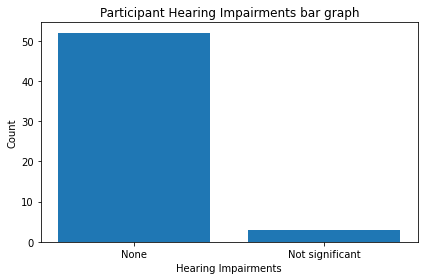

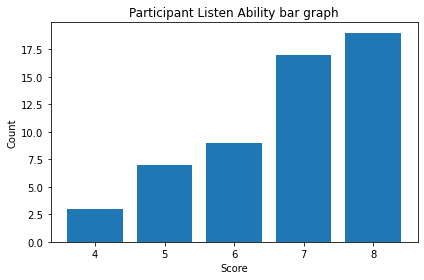

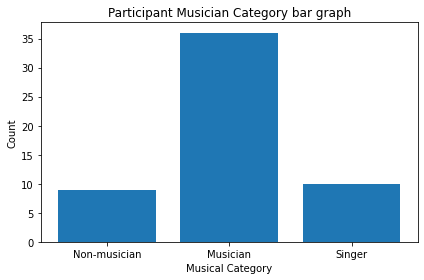

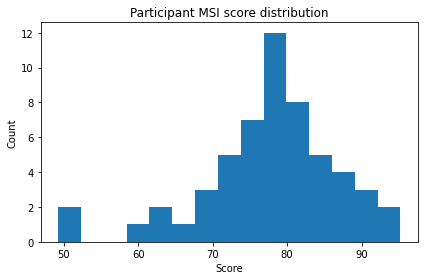

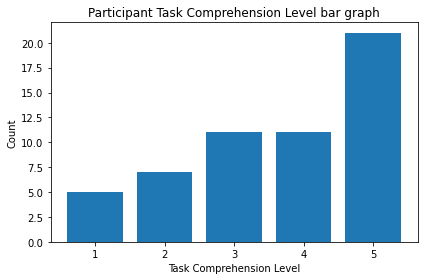

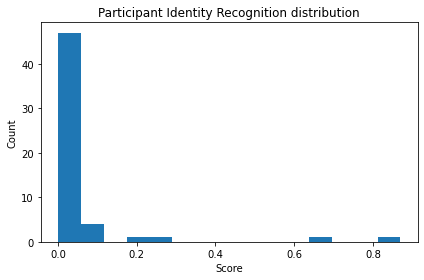

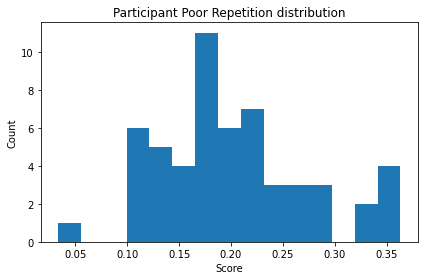

In [23]:
# Each column in the profile array represents a different profile feature (see list above)

directory_name = 'participant_profile_distributions'
for i in range(profile_array.shape[1]):
    profile_feature_list = []
    for experiment_idx in range(num_experiments):
        if i == 5: # if similarity misenditification (zero error)
            # a list saved as a string-byte - convert to string, then to literal list
            corrected_list = ast.literal_eval(profile_array[experiment_idx][i].decode('utf-8'))
            profile_feature_list.append(sum(corrected_list))
            
        else:
            profile_feature_list.append(float(profile_array[experiment_idx][i]))
    unique_values = list(set(profile_feature_list))
    value_counts = [profile_feature_list.count(value) for value in unique_values]


    # decide whether bar/hist for discrete/continuous data
    if i < 3 or i == 4: # if i = 0,1,2,4
        plt.bar(profile_label_dict[profile_label_names[i]][1], value_counts)
        rep_type = 'bar graph'
    else:
        plt.hist(profile_feature_list, bins=15)
        rep_type = 'distribution'
        
    os.makedirs(directory_name, exist_ok=True)
    title =f'Participant {profile_label_names[i]} {rep_type}'
    plt.xlabel(profile_label_dict[profile_label_names[i]][0])
    plt.ylabel('Count')
    plt.title(title)
    plt.tight_layout()
    if save_plot:
        plt.savefig(directory_name +'/' +title)
    plt.show()
    plt.close()

### Plot stacked histogram of ages across all participants

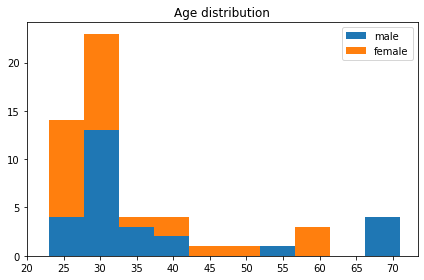

Participant age mean = 35.30909090909091, std = 12.907887267830018.


In [24]:

ages = []
male_ages=[]
female_ages=[]
for experiment_idx in range(num_experiments):
    ages.append(int(h5_ram['participant_info'][experiment_idx][7]))
#     print(h5_ram['participant_info'][experiment_idx][8].decode("utf-8"))
    if h5_ram['participant_info'][experiment_idx][8].decode("utf-8")=='m':
        gender = 0
        male_ages.append(int(h5_ram['participant_info'][experiment_idx][7]))
    elif h5_ram['participant_info'][experiment_idx][8].decode("utf-8")=='f':
        gender = 1
        female_ages.append(int(h5_ram['participant_info'][experiment_idx][7]))
    else:
        pdb.set_trace()
        raise NotImplementedError

    
plt.hist([male_ages, female_ages], stacked=True, bins=10)
os.makedirs(directory_name, exist_ok=True)
title ='Age distribution'
plt.title(title)
plt.tight_layout()
plt.xticks(range(20, 75, 5))
labels = ['male', 'female']
plt.legend(labels)
if save_plot:
    plt.savefig(directory_name +'/' +'Distribution of Ages')
plt.show()
plt.close()

male_ages_array = np.asarray(male_ages)
female_ages_array = np.asarray(female_ages)
all_ages = np.concatenate((male_ages_array, female_ages_array))
print('Participant age mean = {0}, std = {1}.'.format(np.mean(all_ages), np.std(all_ages)))

### Plot stacked bar graph of musician abilities across all participants

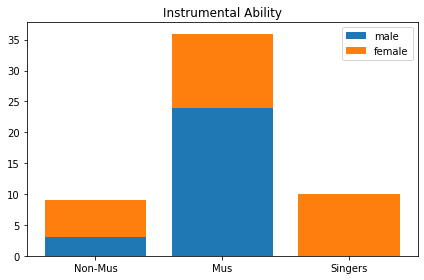

In [25]:
# PLOT GRAPH OF THE THREE CATEGORIES OF INSTRUMENTAL ABILITY USED IN THIS STUDY
men_non_mus = 0
men_mus = 0
men_singer_mus= 0
women_non_mus = 0
women_mus = 0
women_singer_mus= 0
N = 3
ind = np.arange(N)
for experiment_idx in range(num_experiments):
    if h5_ram['participant_info'][experiment_idx][24].decode("utf-8")=='0':
        if h5_ram['participant_info'][experiment_idx][8].decode("utf-8")=='m':
            men_non_mus += 1
        else:
            women_non_mus +=1
    elif h5_ram['participant_info'][experiment_idx][24].decode("utf-8")=='1':
        if h5_ram['participant_info'][experiment_idx][8].decode("utf-8")=='m':
            men_mus += 1
        else:
            women_mus +=1
    elif h5_ram['participant_info'][experiment_idx][24].decode("utf-8")=='2':
        if h5_ram['participant_info'][experiment_idx][8].decode("utf-8")=='m':
            men_singer_mus += 1
        else:
            women_singer_mus +=1

p1 = plt.bar(ind, (men_non_mus, men_mus, men_singer_mus))
p2 = plt.bar(ind, (women_non_mus, women_mus, women_singer_mus), bottom=(men_non_mus, men_mus, men_singer_mus))
os.makedirs(directory_name, exist_ok=True)
title ='Instrumental Ability'
plt.title(title)
plt.xticks(ind, ('Non-Mus', 'Mus', 'Singers'))
plt.tight_layout()
labels = ['male', 'female']
plt.legend((p1[0], p2[0]), ('male', 'female'))
if save_plot:
    plt.savefig(directory_name +'/' +'Instrumental Ability')
plt.show()
plt.close()

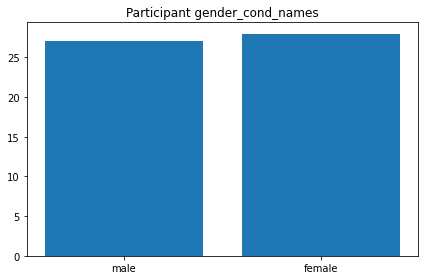

In [26]:
# PLOT GENDER GRAPH
male = 0
female = 0
for experiment_idx in range(num_experiments):
    if h5_ram['participant_info'][experiment_idx][8].decode("utf-8")=='m':
        male += 1
    elif h5_ram['participant_info'][experiment_idx][8].decode("utf-8")=='f':
        female += 1
gender_count = [male, female]
labels = ['male', 'female']

plt.bar(labels, gender_count)
os.makedirs(directory_name, exist_ok=True)
plt.title('Participant gender_cond_names')
plt.tight_layout()
if save_plot:
    plt.savefig(directory_name +'/' +'Participant gender_cond_names')
plt.show()
plt.close()

# Clustering Analysis

In [27]:
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

In [28]:
all_indices = np.arange(num_experiments)
k_range = range(2,14)

In [30]:
all_elbows = get_elbow_array(h5_ram, all_indices, range(1,14), 'all_elbows', show_plot=False, s_param=0.25)

In [31]:
all_elbows

array([4., 3., 3., 4., 3., 4., 2., 4., 3., 3., 5., 4., 4., 4., 4., 5., 3.,
       5., 3., 4., 5., 4., 5., 5., 3., 4., 4., 3., 5., 3., 4., 3., 4., 3.,
       3., 3., 3., 4., 4., 4., 4., 3., 4., 5., 3., 4., 4., 3., 4., 5., 4.,
       4., 3., 4., 2.])

In [32]:
cluster_metric_types = [
    'km_sil_scores',
    'km_acc_scores',
    'agg_sil_scores',
    'agg_acc_scores'
]

## 'Best k-value' distribution across all participants

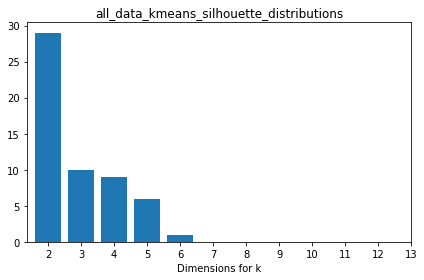

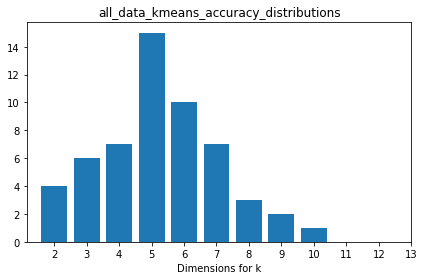

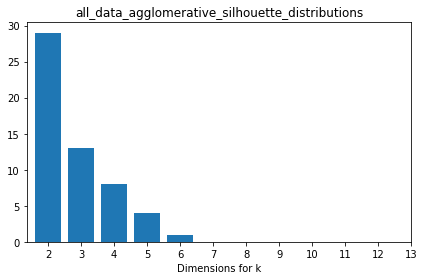

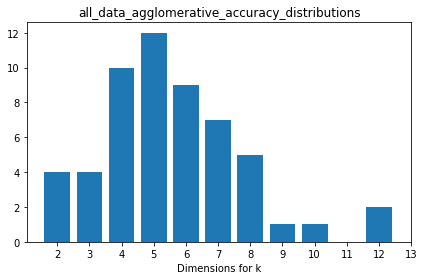

In [34]:
k_range = range(2,14)
km_sil_scores, best_kmeans_sil_ks = find_best_k_values(h5=h5_ram,
                                                         indices=all_indices,
                                                         condition_name='all_data',
                                                         k=k_range,
                                                         cluster_algorithm='kmeans',
                                                         score_type='silhouette',
                                                         show_plot=True)
km_acc_scores, best_kmeans_acc_ks = find_best_k_values(h5=h5_ram,
                                                         indices=all_indices,
                                                         condition_name='all_data',
                                                         k=k_range,
                                                         cluster_algorithm='kmeans',
                                                         score_type='accuracy',
                                                         show_plot=True)
agg_sil_scores, best_agg_sil_ks = find_best_k_values(h5=h5_ram,
                                                         indices=all_indices,
                                                         condition_name='all_data',
                                                         k=k_range,
                                                         cluster_algorithm='agglomerative',
                                                         score_type='silhouette',
                                                         show_plot=True)
agg_acc_scores, best_agg_sil_ks = find_best_k_values(h5=h5_ram,
                                                         indices=all_indices,
                                                         condition_name='all_data',
                                                         k=k_range,
                                                         cluster_algorithm='agglomerative',
                                                         score_type='accuracy',
                                                         show_plot=True)

In [35]:
# GENERATE TWO LISTS OF BEST K VALUES USING ELBOW AND SILHOUETTE TECHNIQUES

def get_scores_for_cond_indices(h5_ram, indices_list, condition_name, k, plots):
    print(f'{condition_name.upper()} \n')
    agg_sil_score, best_agg_sil = find_best_k_values(h5=h5_ram,
                                 indices=indices_list,
                                 condition_name=condition_name,
                                 k=k,
                                 cluster_algorithm='agglomerative',
                                 score_type='silhouette',
                                 show_plot=True)
    agg_acc_score, best_agg_acc = find_best_k_values(h5=h5_ram,
                                 indices=indices_list,
                                 condition_name=condition_name,
                                 k=k,
                                 cluster_algorithm='agglomerative',
                                 score_type='accuracy',
                                 show_plot=True)
    
    return agg_sil_score, best_agg_sil, agg_acc_score, best_agg_acc

ALL_DATA 



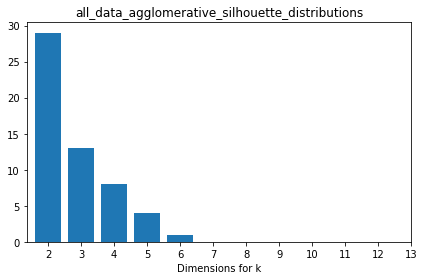

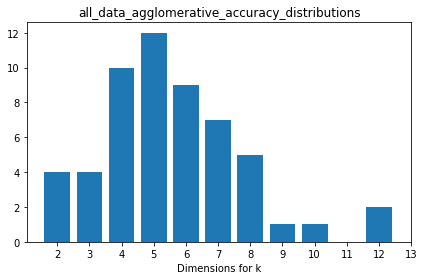

In [36]:
all_indicies_condition = get_scores_for_cond_indices(h5_ram, all_indices, 'all_data', k_range, plots=True)

LOWS 



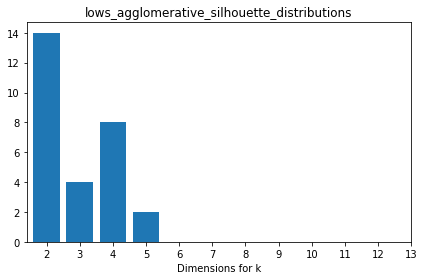

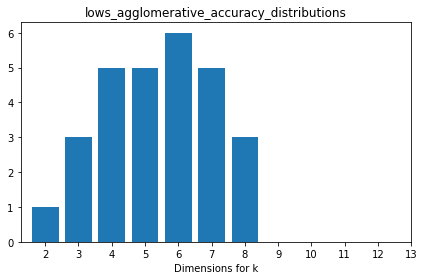

HIGHS 



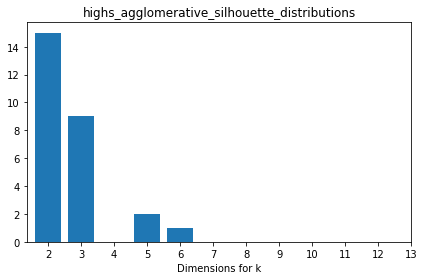

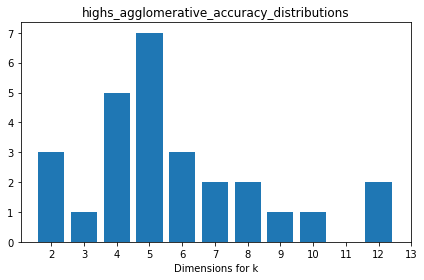

MALE 



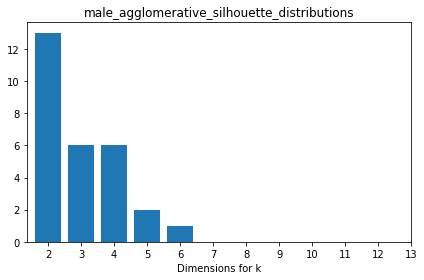

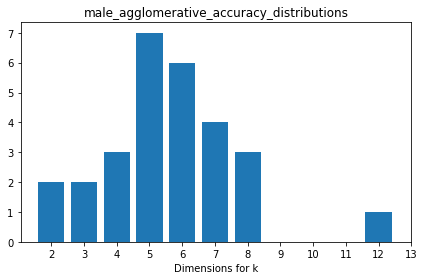

FEMALE 



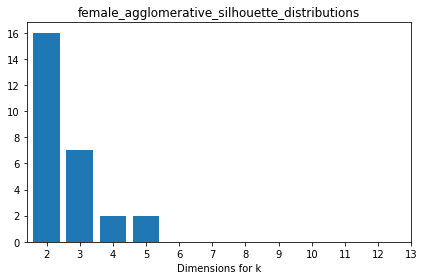

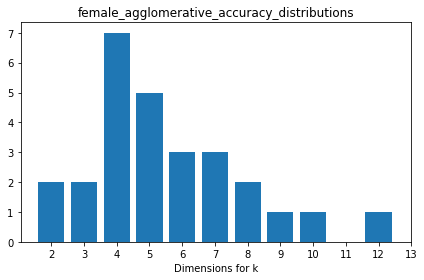

In [37]:
scores_by_condition = []
for i in range(len(indices_grouped_by_condition_groups)):
    if i<2:
        continue
    cond_group = indices_grouped_by_condition_groups[i]
    cond_group_name = group_names[i]
    for j in range(len(cond_group)):
        indices_of_cond = cond_group[j]
        cond_name = condition_names[i][j]
        scores = get_scores_for_cond_indices(h5_ram, indices_of_cond, cond_name, k_range, plots=True)
        scores_by_condition.append(scores)

In [38]:
scores_by_condition

[(array([0.48877027, 0.35376109, 0.40836301, 0.68410334, 0.28555297,
         0.36662855, 0.19262445, 0.40094418, 0.51280761, 0.24843527,
         0.2933079 , 0.20326491, 0.33869546, 0.51696851, 0.48570992,
         0.32629398, 0.59206532, 0.40508533, 0.45346605, 0.36948823,
         0.39072662, 0.43894145, 0.20505283, 0.29064406, 0.39825552,
         0.50554068, 0.31237539, 0.32966539]),
  [3,
   2,
   2,
   2,
   4,
   4,
   2,
   3,
   2,
   5,
   4,
   3,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   4,
   5,
   4,
   4,
   2,
   4,
   3,
   4,
   2],
  array([ 0.52054795,  0.28205128,  0.73076923,  0.28409091,  0.71232877,
          0.58278146, -0.06622517,  0.4939759 ,  0.73076923,  0.1369863 ,
          0.73076923,  0.08695652,  0.39735099,  0.24096386,  0.09677419,
          0.58278146,  0.47311828,  0.01282051,  0.17204301,  0.55128205,
          0.24096386,  0.3253012 ,  0.55128205,  0.02649007,  0.73076923,
          0.1192053 ,  0.30463576,  0.23287671]),
  [6,
   3,
   7,
 

### The proceeding edited code is redundant because of the newer function find_best_k_values() that we now use above.

In [39]:
#LOOKS OVER EACH PARTICIPANT'S RATINGS, ASSESSING THE SCORE OF ELBOW AND SILHOUETTE (ARRANGED BY SUBGROUP)
# elbow_groups=[]
# ks_from_silhouette_groups=[]
# indices_groups_list_names = ['indices_grouped_by_session', 'indices_grouped_by_singer', 'indices_grouped_by_register', 'indices_grouped_by_gender']
# for grp_idx, group_indices in enumerate(indices_grouped_by_condition_groups):
#     elbow_condition_list = []
#     silhouette_condition_list = []
#     for con_idx, condition_indices in enumerate(group_indices):
#         ks_from_silhouettes = util.get_k_array_from_silhouettes(h5_ram, condition_indices, range(2,14), indices_groups_list_names[grp_idx]+' - Condition '+str(con_idx), show_plot)
#         elbows = util.get_elbow_array(h5_ram, condition_indices, range(1,14), indices_groups_list_names[grp_idx]+' - Condition '+str(con_idx), show_plot, 1.0)
#         silhouette_condition_list.append(ks_from_silhouettes)
#         elbow_condition_list.append(elbows)
#     elbow_groups.append(elbow_condition_list)
#     ks_from_silhouette_groups.append(silhouette_condition_list)
    

In [40]:
# # LOOKS OVER EACH PARTICIPANT AND GENERATES METRIC SCORES FOR THEIR CLUSTERING BEHAVIOUR
# cluster_perf_2 = np.empty((0,6))
# cluster_perf_5 = np.empty((0,6))
# for idx in range(num_experiments):
#     for best_num_clusters in [2,5]:
#     #    print(idx, h5_ram['participant_info'][idx])
#         rearranged_dissim_matrix = h5_ram['dissim_matrix'][idx]
#         rearranged_ref_audio = h5_ram['rearrangedReferenceAudioNames'][idx]
#         rearranged_class_list = util.strings_to_classes(rearranged_ref_audio, label_list)
#     #    dissim_matrix = np.around(rearranged_dissim_matrix, 2)
#         if show_plot == True:
#             util.display_dissim_heatmaps(rearranged_dissim_matrix, rearranged_ref_audio)
#         mds_from_dissim_matrix(rearranged_dissim_matrix, rearranged_ref_audio, 3, show_plot=show_plot)
#         # CLUSTER
#         # dendrogram = sch.dendrogram(sch.linkage(rearranged_dissim_matrix, method='ward'))
#         hc = AgglomerativeClustering(n_clusters=best_num_clusters, affinity = 'euclidean', linkage='ward')
#         hc_clustering = hc.fit_predict(rearranged_dissim_matrix)
#         # the silhouette score is higher when clusters are dense - bounded between -1 for incorrect clustering and
#         # 1 for dense clustering. Around zero when clusters are overlapping
#         hc_sil_score = silhouette_score(rearranged_dissim_matrix, hc_clustering, metric='euclidean')   
#         km = KMeans(n_clusters=best_num_clusters)
#         cluster_predictions = km.fit_predict(rearranged_dissim_matrix)
#         sse = km.inertia_
#         kmeans_cluster_accuracy = adjusted_rand_score(cluster_predictions, rearranged_class_list)
#         hc_cluster_accuracy = adjusted_rand_score(hc_clustering, rearranged_class_list)
#         kmeans_hc_accuracy_comparison = adjusted_rand_score(hc_clustering, kmeans_cluster_list)
#         if best_num_clusters == 2:
#             cluster_perf_2 = np.append(cluster_perf_2, np.array([[idx, sse, kmeans_cluster_accuracy,
#                                                hc_cluster_accuracy, hc_sil_score, kmeans_hc_accuracy_comparison]]), axis=0)
#         else:
#             cluster_perf_5 = np.append(cluster_perf_5, np.array([[idx, sse, kmeans_cluster_accuracy,
#                                                hc_cluster_accuracy, hc_sil_score, kmeans_hc_accuracy_comparison]]), axis=0)

### The following cell analyses similarity between participants.

The results are underwhelming, where there are very little values in the meta dissim matrix that reveal strong correlation between datapoints. However, we do not have a frame of reference as to how linear or relevant these correlation values should be to reflect a suitable amount of similarity, or conversely, a suitable tolerance for dissimilarity.

For 1 clusters, the data splits in the following way:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
For 2 clusters, the data splits in the following way:
[1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0
 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 1]
For 3 clusters, the data splits in the following way:
[0 1 1 0 1 1 1 2 0 1 0 0 1 0 0 0 1 2 1 2 0 2 0 2 0 0 0 0 2 0 0 0 0 0 0 0 1
 2 1 1 1 0 1 0 0 0 2 0 1 1 2 0 2 1 0]
For 4 clusters, the data splits in the following way:
[0 1 1 3 1 1 1 2 3 1 0 3 1 0 0 0 1 2 1 2 3 2 0 2 0 0 3 3 2 0 3 0 0 3 0 3 1
 2 1 1 1 0 1 0 3 0 2 0 1 1 2 3 2 1 0]
For 5 clusters, the data splits in the following way:
[4 0 0 3 0 0 0 2 3 0 4 3 0 1 1 1 0 2 0 2 3 2 4 2 4 1 3 3 2 1 3 1 1 3 1 3 0
 2 0 0 0 1 0 1 3 1 2 1 0 0 2 3 2 0 1]
For 6 clusters, the data splits in the following way:
[4 5 5 3 5 1 5 2 3 1 4 3 1 0 0 0 1 2 5 2 3 2 4 2 4 0 3 3 2 0 3 0 0 3 0 3 5
 2 1 1 1 0 1 0 3 0 2 0 5 1 2 3 2 1 0

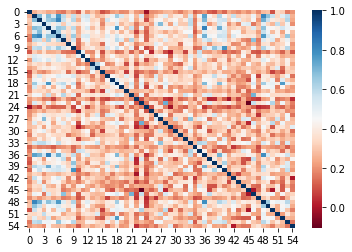

In [41]:
import seaborn as sns

"""CHECH FOR OUTLIERS AMONG PARTICIPANTS' DISSIMILARITY MATRICES
It can be observed from that the distribution between clusters in hc_new_clustering is fairly even,
and therefore no datasets are considered outliers"""

# collect all matrices as flattened vectors
flattened_matrices = np.empty((0,225))
for idx in range(num_experiments):
    rearranged_dissim_matrix = h5_ram['dissim_matrix_dim15'][idx]
    flattened_dissim_matrix = rearranged_dissim_matrix.flatten()
    flattened_dissim_matrix = flattened_dissim_matrix.reshape(-1, len(flattened_dissim_matrix))
    flattened_matrices = np.append(flattened_matrices,flattened_dissim_matrix, axis=0)

# convert to pandas and get spearman's correlation
df = pd.DataFrame(flattened_matrices)
df_tran = df.T
df_tran_corr = df_tran.corr('spearman')

if True:
    sns.heatmap(df_tran_corr, cmap = "RdBu")
# perform hc clustering to find outlier clusters that are behaving abnormally
hcs = []
for i in range(1,10):
    new_hc = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage='ward')
    hc_new_clustering = new_hc.fit_predict(df_tran_corr)
    print('For {0} clusters, the data splits in the following way:'.format(i))
    print(hc_new_clustering)
    hcs.append(hc_new_clustering)

# Statistical Analysis

### The cells below are commented out as they use old and unnecessary objects for analysis, and removes data that under our revised process should be done already

In [42]:
# # GENERATE NUMPY WITH CLUSTERING AND PROFILE METRICS
# profile_clustering_measures = np.concatenate((profile_array, cluster_perf_5), axis=1)

# #REMOVE ALL UNNECESSARY FEATURES/METRICS
# profile_clustering_measures_reduced = np.delete(profile_clustering_measures, 13, 1) # delete hc vrs kmeans solution similarity
# profile_clustering_measures_reduced = np.delete(profile_clustering_measures_reduced, 10, 1) # delete kmeans acc as we're using hc accuracy
# profile_clustering_measures_reduced = np.delete(profile_clustering_measures_reduced, 8, 1) # delete indices column that came from cluster_perf_5
# profile_clustering_measures_reduced = np.delete(profile_clustering_measures_reduced, 0, 1) # delete indices column that came from profile_array

# # CREATE VERSION OF CLUSTER-PROFILE FEATURES WHERE PARTICIPANTS WITH INCONCLUSIVE FEEDBACK (VALUE=5) ARE REMOVED
# no_task_feedback_indices = np.where(profile_clustering_measures_reduced[:,4]==5)[0]
# no_task_feedback_indices[::-1].sort() # reverses the numpy
# profile_clustering_measures_reduced_shortened = profile_clustering_measures_reduced.copy()
# for i in no_task_feedback_indices:
#     profile_clustering_measures_reduced_shortened = np.delete(profile_clustering_measures_reduced_shortened, i, 0)

In [43]:
"""Collect metrics from cluster_perf_X lists (which contained diff clustering metrics)
and organise these in nested lists in the following sequence:
    clusterX_scores_list -> condition groups -> metric groups -> values"""

# num_variables = len(cluster_perf_2[0])
# cluster2_scores_list = []
# for conditions_indices_list in indices_grouped_by_condition_groups:
#     variables_list = []
#     for variable_col in range(1, num_variables):
#         values_list = []
#         for idx in conditions_indices_list:
#             values_list.append(cluster_perf_2[idx,variable_col])
#         variables_list.append(values_list)
#     cluster2_scores_list.append(variables_list)
    
# cluster5_scores_list = []
# for conditions_indices_list in indices_grouped_by_condition_groups:
#     variables_list = []
#     for variable_col in range(1, num_variables):
#         values_list = []
#         for idx in conditions_indices_list:
#             values_list.append(cluster_perf_5[idx,variable_col])
#         variables_list.append(values_list)
#     cluster5_scores_list.append(variables_list)

'Collect metrics from cluster_perf_X lists (which contained diff clustering metrics)\nand organise these in nested lists in the following sequence:\n    clusterX_scores_list -> condition groups -> metric groups -> values'

### CORRELATION BETWEEN CLUSTER AND PROFILE METRICS

### Correlation between Kmeans and Agglomerative metrics

('km_sil_scores', 'agg_sil_scores', 0.9891774891774894, 7.359483960295398e-46)


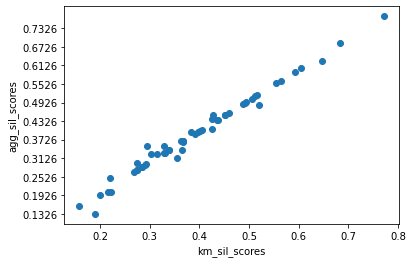

('km_acc_scores', 'agg_acc_scores', 0.9597407522641462, 6.7162878498129875e-31)


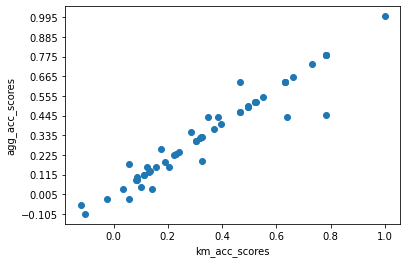

{'km_acc_scores x agg_acc_scores': ('km_acc_scores',
  'agg_acc_scores',
  0.9597407522641462,
  6.7162878498129875e-31)}

In [48]:
cluster_algorithms = np.concatenate((km_sil_scores.reshape(-1,1), agg_sil_scores.reshape(-1,1)), axis=1)
cluster_corr_dict, cluster_corr_list = array_column_correlations(
    cluster_algorithms,
    [cluster_metric_types[0], cluster_metric_types[2]],
    0.05,
    'spearmanr',
    show_plot=True)
cluster_corr_dict

cluster_algorithms = np.concatenate((km_acc_scores.reshape(-1,1), agg_acc_scores.reshape(-1,1)), axis=1)
cluster_corr_dict, cluster_corr_list = array_column_correlations(
    cluster_algorithms,
    [cluster_metric_types[1], cluster_metric_types[3]],
    0.05,
    'spearmanr',
    show_plot=True)
cluster_corr_dict

### As km and agg are so similar in results, only one of them was retained to reduce comparative data. Agglomerative metrics were kept as this is the more deterministic algorithm of the two

### Present results for Spearman rank without km 

('Musician Category', 'MSI score', 0.48075937362017745, 0.00020309564701750818)


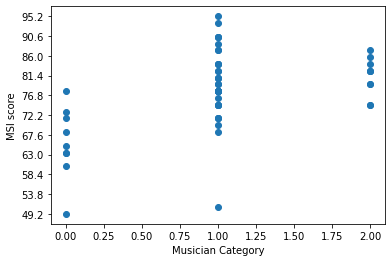

('Musician Category', 'agg_sil_scores', 0.3255142489191239, 0.015305028373292614)


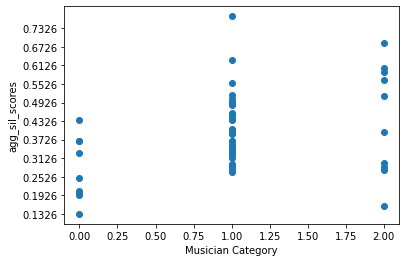

('Musician Category', 'agg_acc_scores', 0.47647223562383706, 0.0002357042400249751)


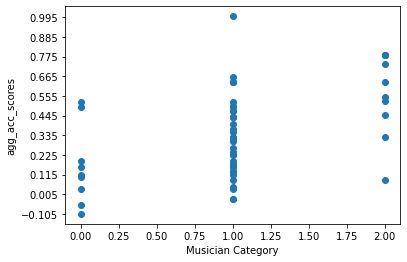

('MSI score', 'agg_acc_scores', 0.47108753009695414, 0.00028339651183849026)


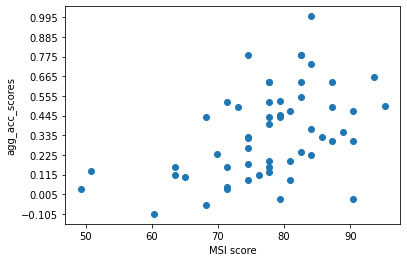

('Poor Repetition', 'agg_sil_scores', -0.3666666666666667, 0.005897502537706259)


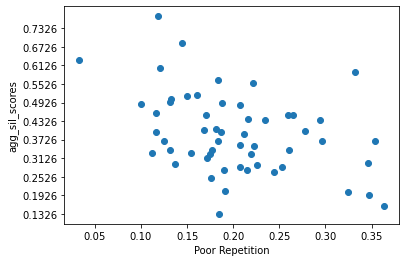

5

In [49]:
# print(profile_array.shape, km_sil_scores.reshape(-1,1).shape)
participant_feats_no_km = np.concatenate((profile_array,
                    agg_sil_scores.reshape(-1,1),
                    agg_acc_scores.reshape(-1,1)),
               axis=1)
# print(participant_feats_no_agg.shape)

correlation_dict, correlation_list = array_column_correlations(
    participant_feats_no_km,
    profile_label_names + [cluster_metric_types[2], cluster_metric_types[3]],
    0.05,
    'spearmanr',
    show_plot=True)
len(correlation_dict)

In [50]:
header = ['feature A', 'feature B', 'correlation', 'p-value']
sorted_correlation_list = sorted(correlation_list, key=lambda x: x[3])
list_to_csvfile([header] + sorted_correlation_list, './spearman_05_significance_for_participant_features.csv')

### TEST FOR DIFFERENCE BETWEEN NONPARAMETRIC DISTRIBUTIONS

In [51]:
# sig_thresh = 0.05
# two_tailed_sig_thresh = sig_thresh/2
# # reports differences between conditions for cluster metrics, class-pair distances
# annotated_results, results = util.nonpara_multiple_variables_test(cluster2_scores_list, two_tailed_sig_thresh)

In [52]:
# annotated_results, results = util.nonpara_multiple_variables_test(cluster5_scores_list, two_tailed_sig_thresh)

### Check for normal distribution using shapiro wilks

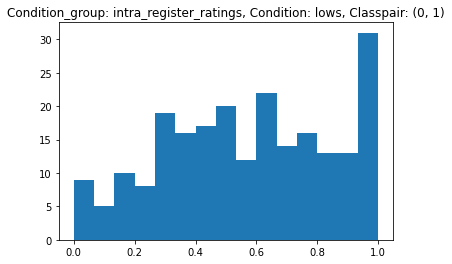

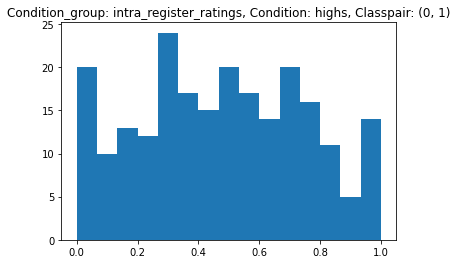

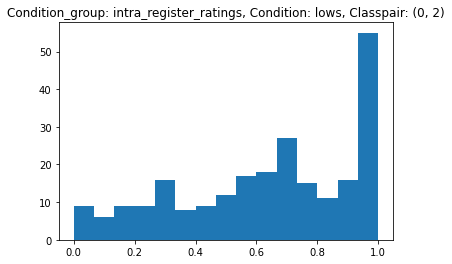

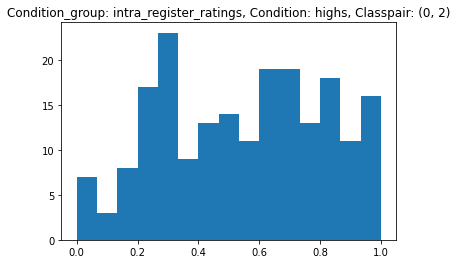

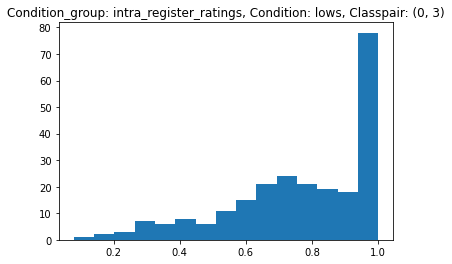

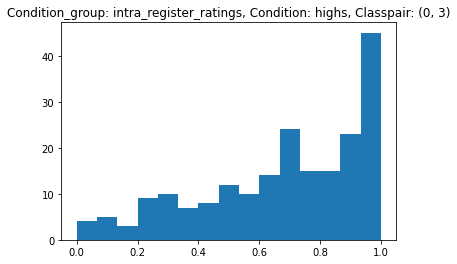

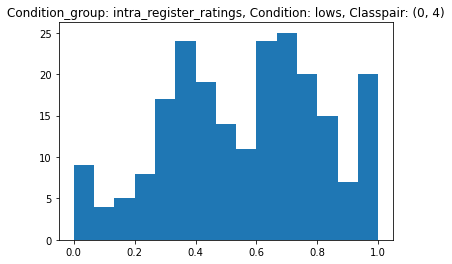

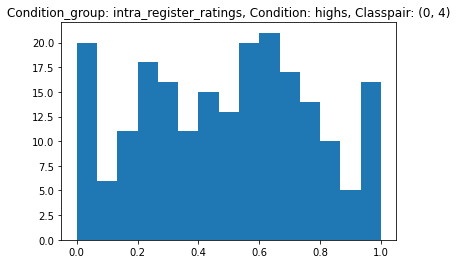

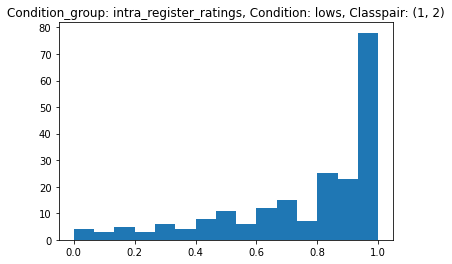

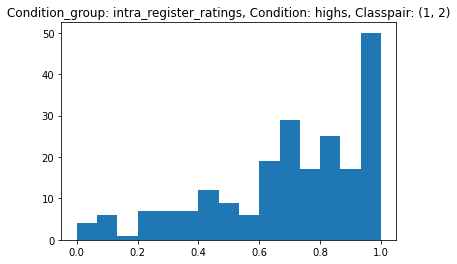

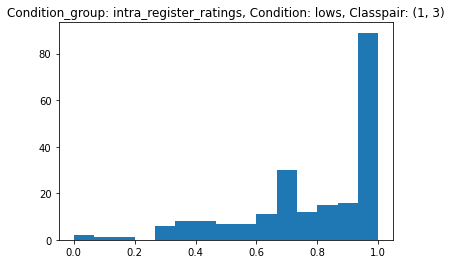

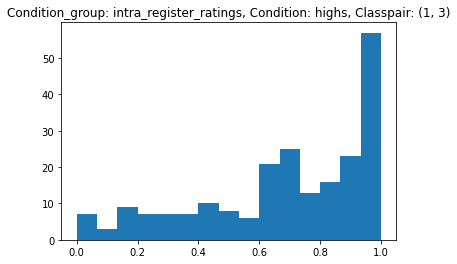

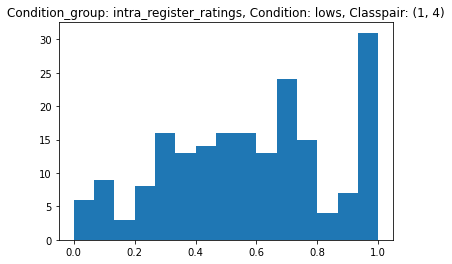

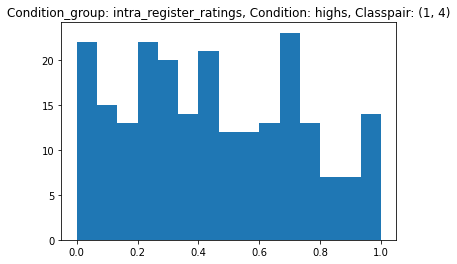

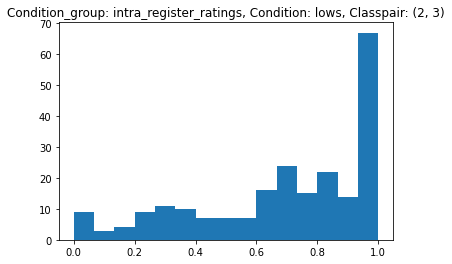

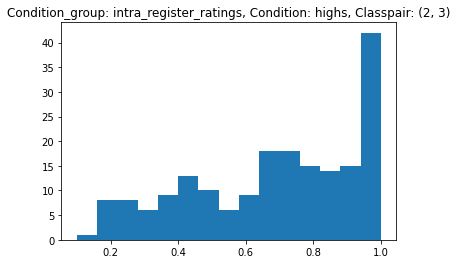

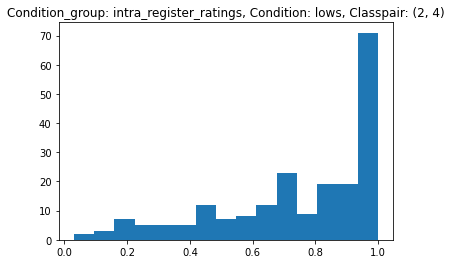

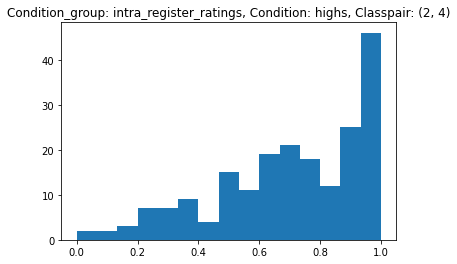

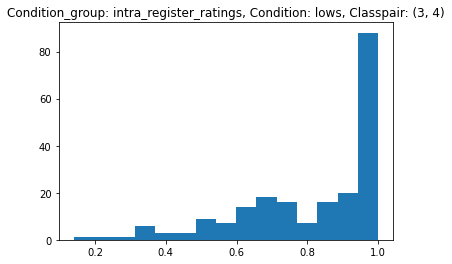

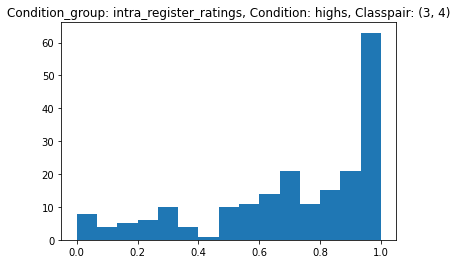

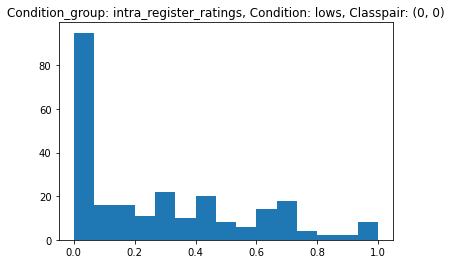

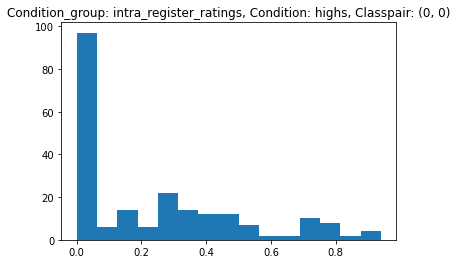

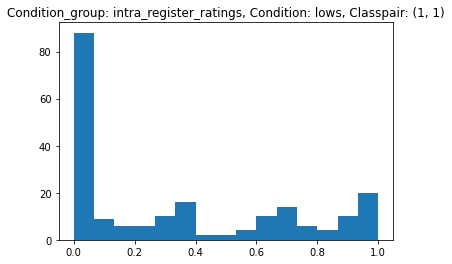

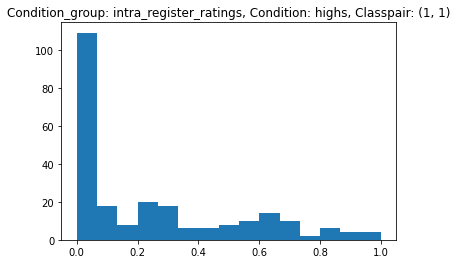

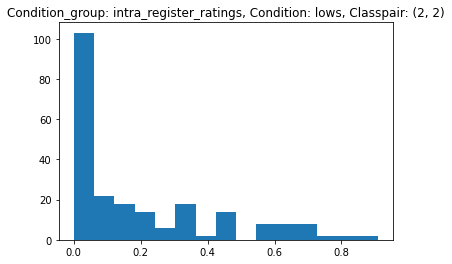

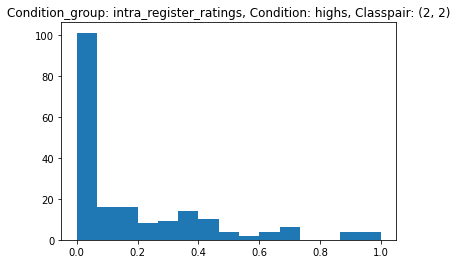

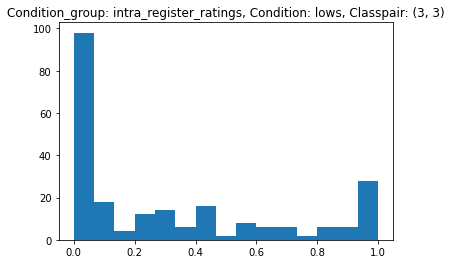

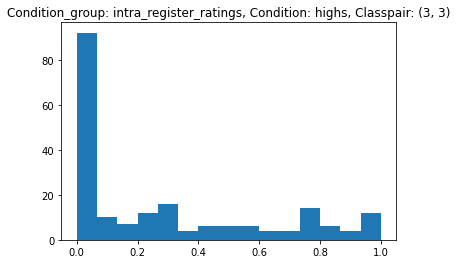

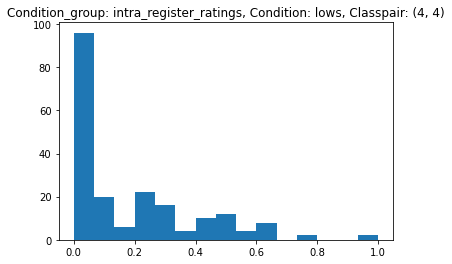

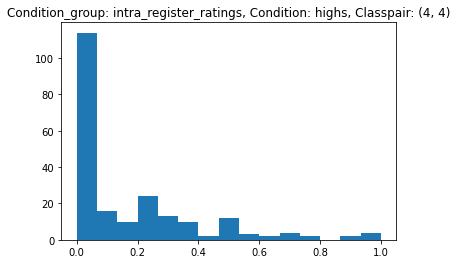

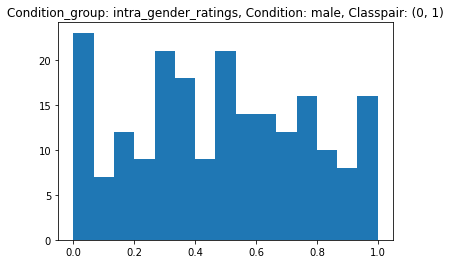

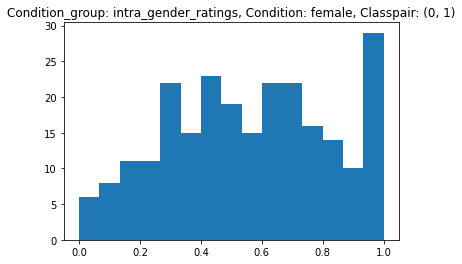

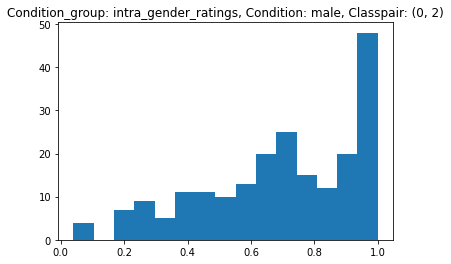

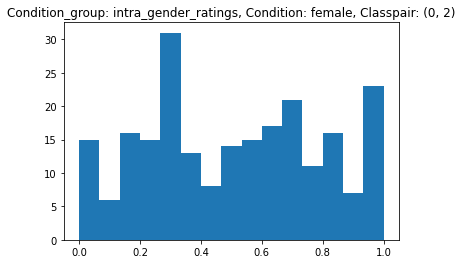

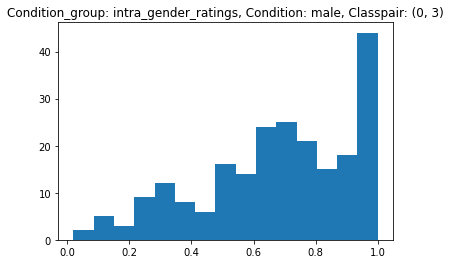

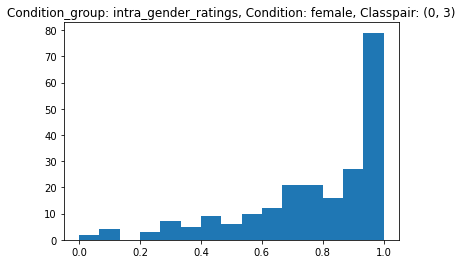

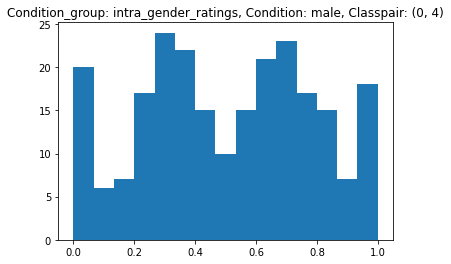

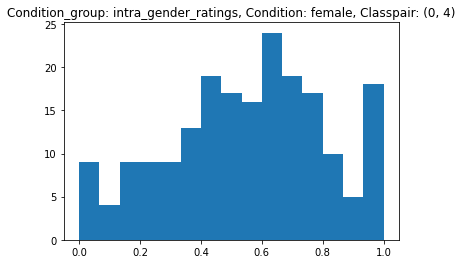

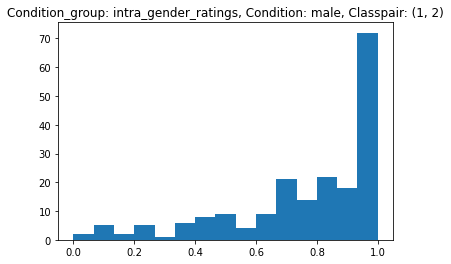

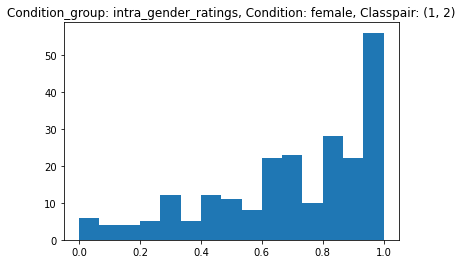

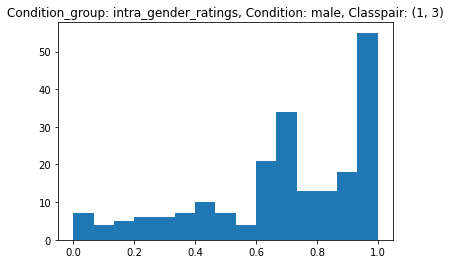

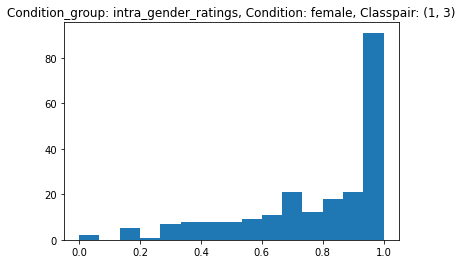

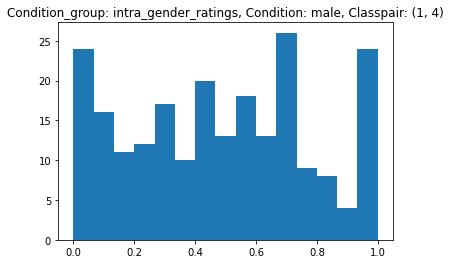

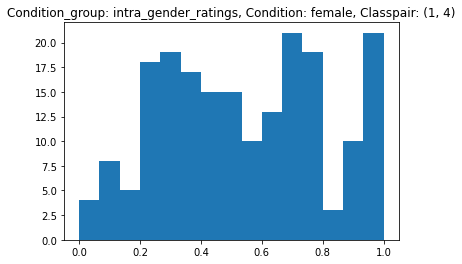

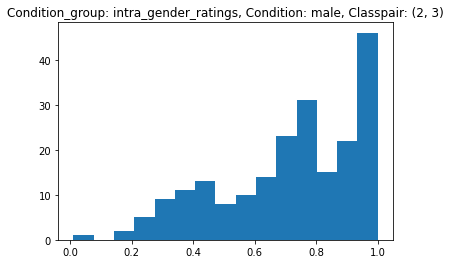

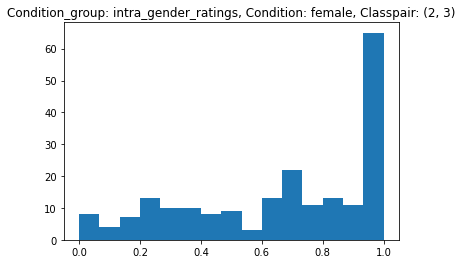

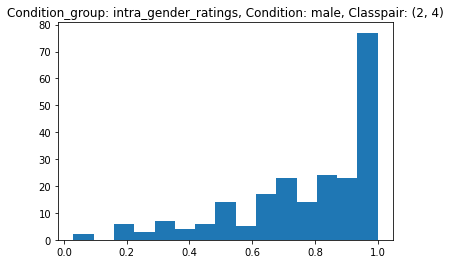

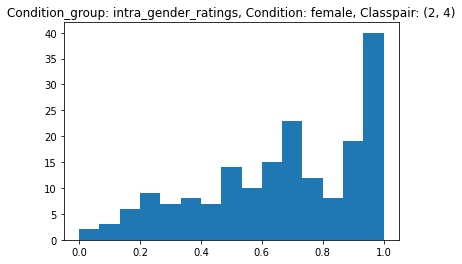

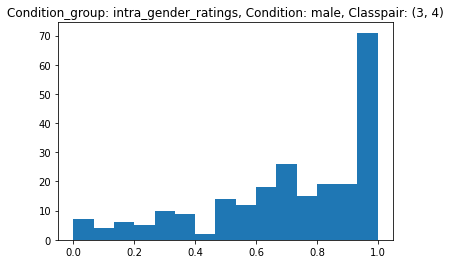

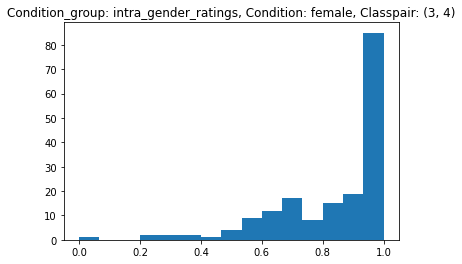

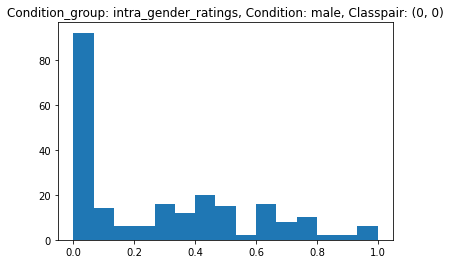

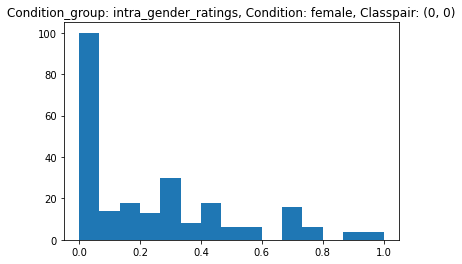

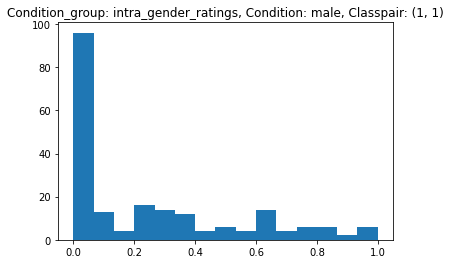

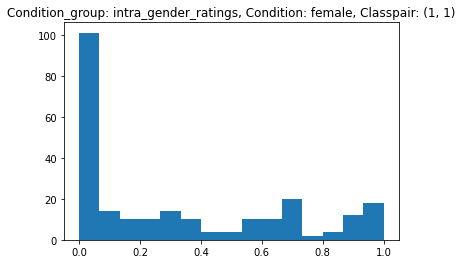

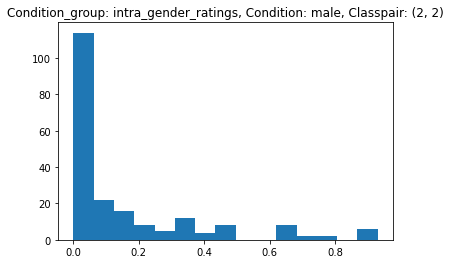

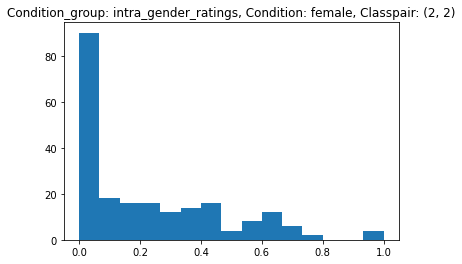

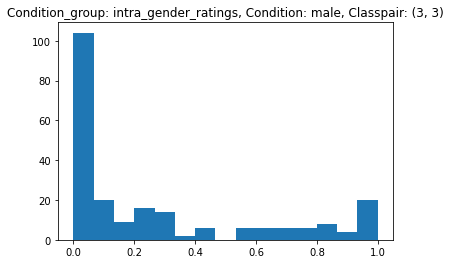

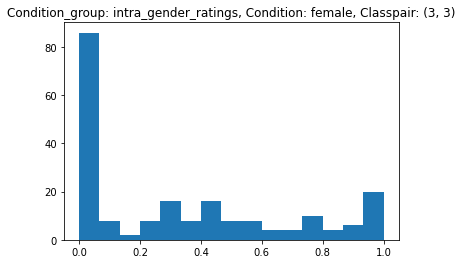

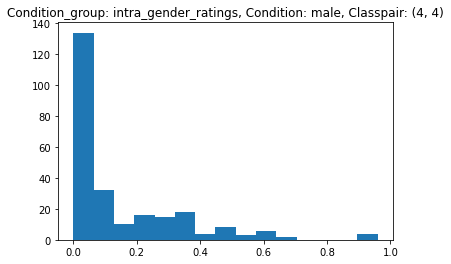

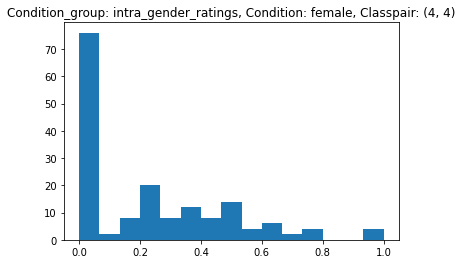

In [53]:
rating_groups_skewness = []
rating_groups_ws = []
rating_groups_ks = []

header = ('count_idx', 'condition_group', 'pairwise rating', 'condition name', 'W value', 'p value')
ws_p_05_normals = [header]

counter = 0
for group_idx, grouping in enumerate(rating_groups):
    
    if group_idx < 2: # ignore session and singer conditions
        continue
        
    data_skewness = []
    data_ws = []
    data_ks = []
    # class_int refers to class_comparison_rating conditions index
    for class_int, class_comparison_ratings in enumerate(grouping):
        #condition_int refers to session_int
        for condition_int, relevant_sessions_group in enumerate(class_comparison_ratings):
            counter += 1
            flattened_list = [rating for session in relevant_sessions_group for rating in session]
            plt.hist(np.asarray(flattened_list), bins=15)
            plt.title(f'Condition_group: {group_names[group_idx]}, Condition: {condition_names[group_idx][condition_int]}, Classpair: {class_pairs[class_int]}')
            plt.show()
            plt.close()
            skewness = stats.skew(flattened_list)
#             print(counter, group_names[group_idx], class_pairs[class_int], len(flattened_list))
            try:
            # SHAPIRO-WILK - if it returns a p value less than the accepted 0.05, data is NOT normal
                W, p = stats.shapiro(flattened_list)
                if p>=0.05:
                    ws_p_05_normals.append((counter, group_names[group_idx], class_pairs[class_int], condition_names[group_idx][condition_int], round(W, 5), round(p, 5)))
            except:
                pdb.set_trace()
    #        print('Shapiro Wilks: W{0} p={1}'.format(W,p))
            D, p2 = stats.kstest(flattened_list, 'norm')
    #        print('Klomogorov-Smirnov: W{0} p={1}'.format(D,p2))
            data_skewness.append((class_pairs[class_int], condition_int, skewness))
            data_ws.append((class_pairs[class_int], condition_int, W, p))
            data_ks.append((class_pairs[class_int], condition_int, D, p2))
    rating_groups_skewness.append(data_skewness)
    rating_groups_ws.append(data_ws)
    rating_groups_ks.append(data_ks)

In [54]:
ws_p_05_normals

[('count_idx',
  'condition_group',
  'pairwise rating',
  'condition name',
  'W value',
  'p value')]

In [55]:
    #ADD HEADERS AND SAVE AS CSV FILE
list_to_csvfile(ws_p_05_normals, './ws_p_05_significance_for_pairwise_distance_distributions.csv')
# ws_p_05_normals, len(ws_p_05_normals)


In [56]:
# ## GENERATE AVERAGE DISTANCES LISTS OF LISTS FOR CLASS PAIR

# directory_name = 'average_class_distance_distributions'
# averaged_groups = []

# for rating_group_idx, rating_group in enumerate(rating_groups):
#     conditions_list = []
    
#     for class_group_idx, class_group in enumerate(rating_group):
#         # get the average of all the distances for each condition of each class of each group  
#         participant_averages_list=[]
        
#         for condition_group_idx, condition_group in enumerate(class_group):
#             # convert multiple scores for each participant into a single average for them
#             participant_averages = []
            
#             for part_idx, participant in enumerate(condition_group):
#                 num_ratings = len(participant)
#                 average = sum(participant)/len(participant)
#                 participant_averages.append(average)

#             if show_plot == True:
#                 plt.hist(participant_averages, bins=10)
#                 os.makedirs(directory_name, exist_ok=True)
#                 title ='Group {0}, Condition {2}, Class pair {1}, Averages Distribution'.format(
#                     rating_group_idx,
#                     class_pairs[class_group_idx],
#                     condition_group_idx
#                 )
                
#                 plt.title(title)
#                 plt.tight_layout()
#                 plt.savefig(directory_name +'/' +title)
#                 plt.show()
#                 plt.close() 
                
#             participant_averages_list.append(participant_averages)
            
#         # add this class to the group for this rating groups
#         conditions_list.append(participant_averages_list)
        
#     averaged_groups.append(conditions_list)

### Generate average distances using nested dicts for class pairs

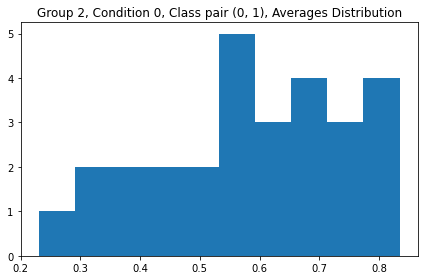

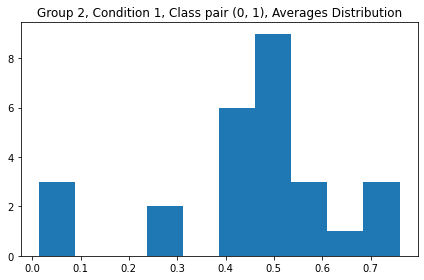

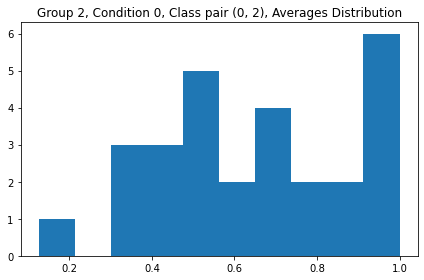

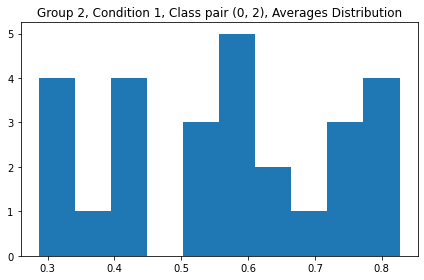

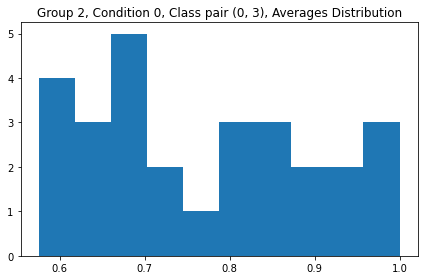

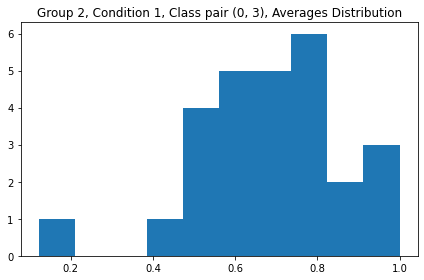

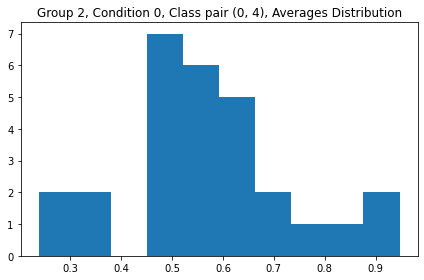

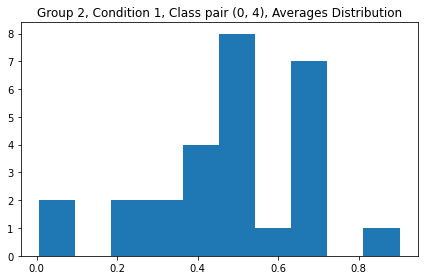

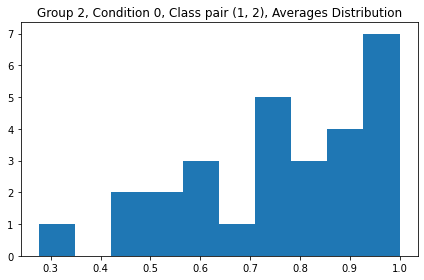

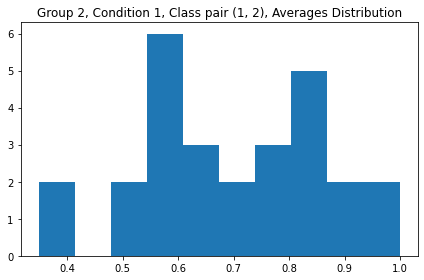

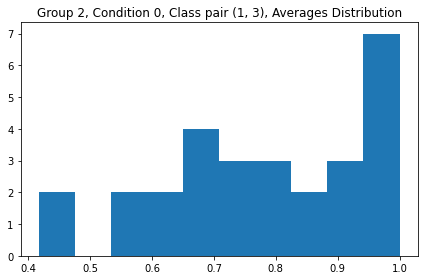

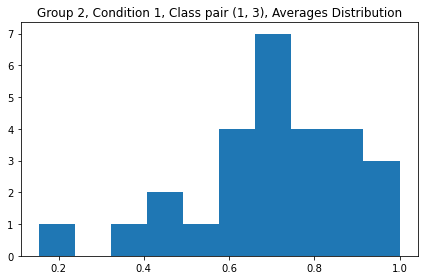

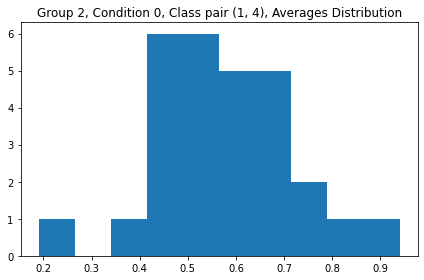

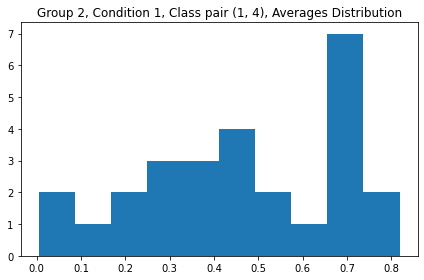

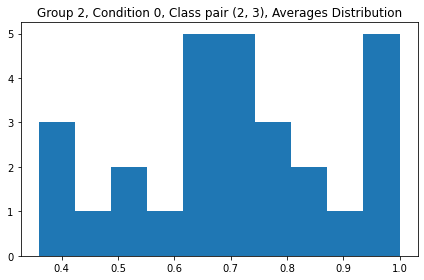

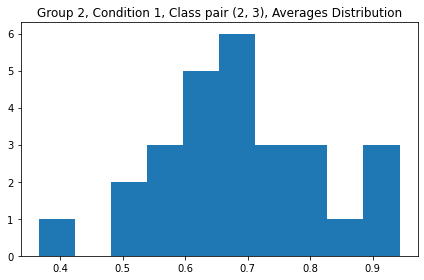

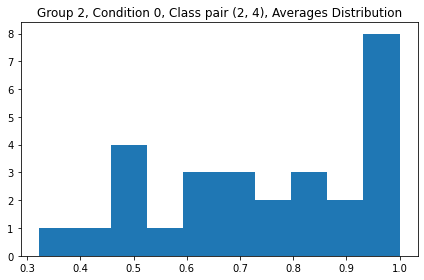

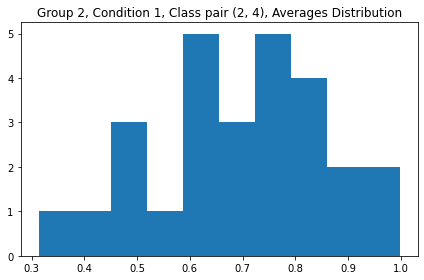

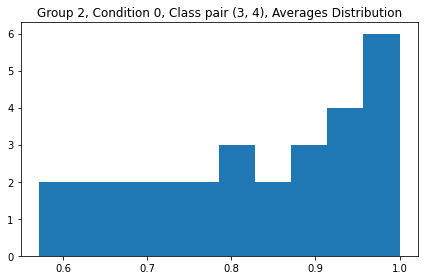

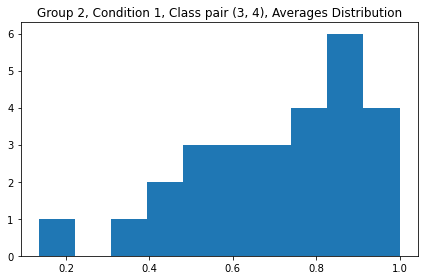

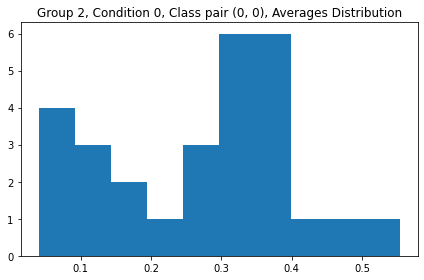

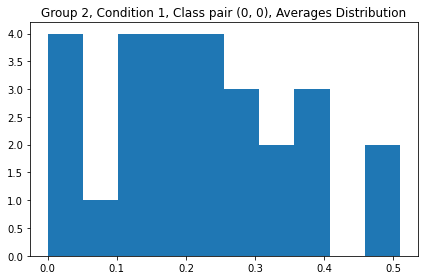

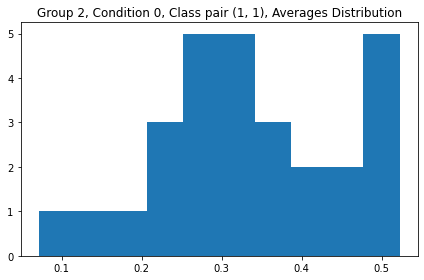

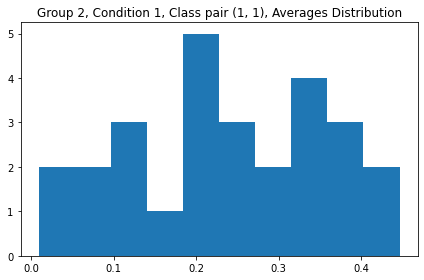

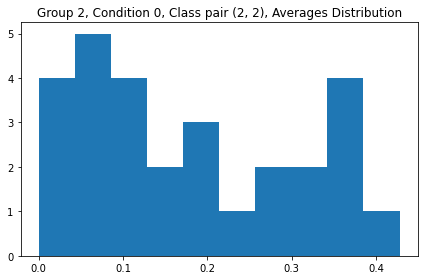

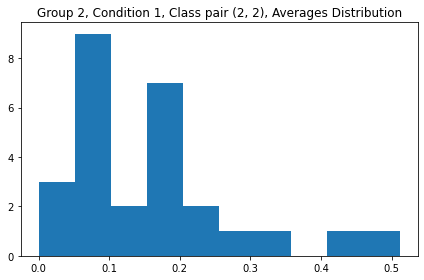

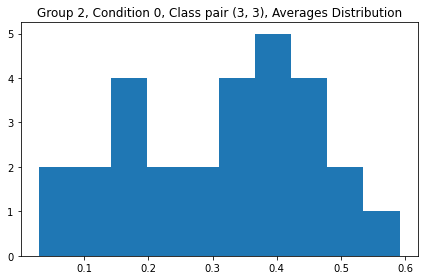

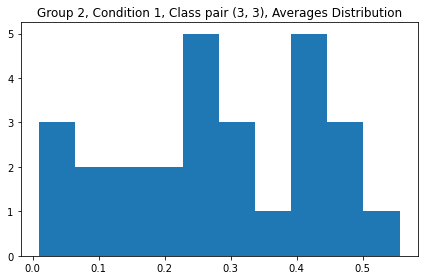

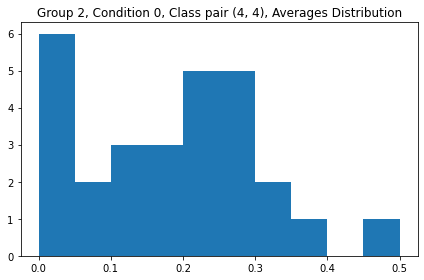

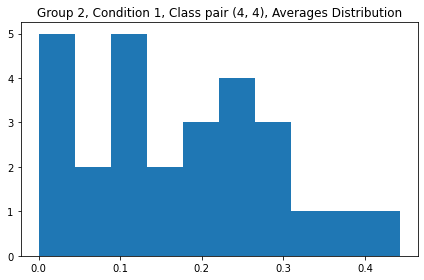

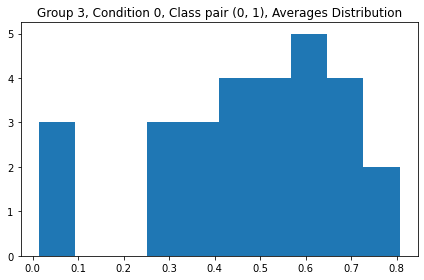

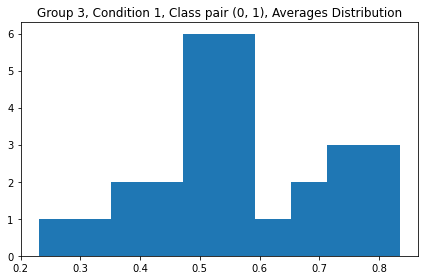

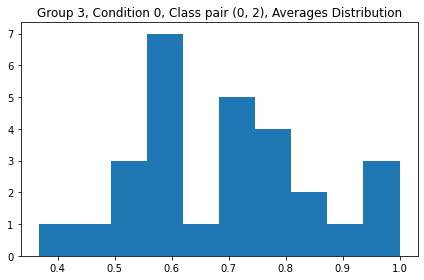

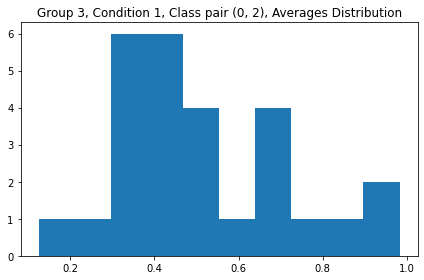

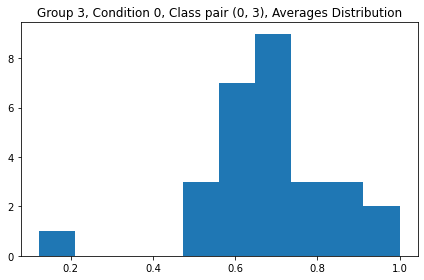

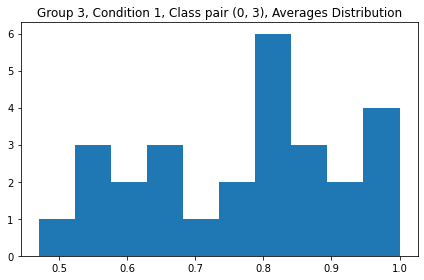

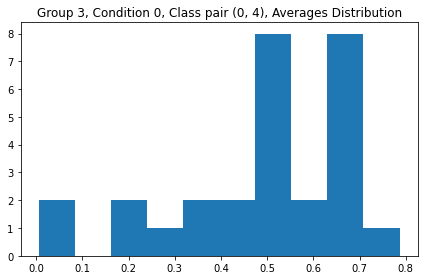

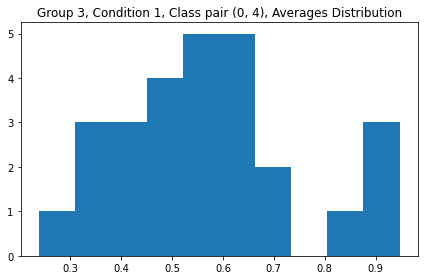

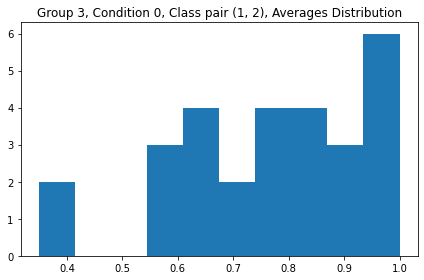

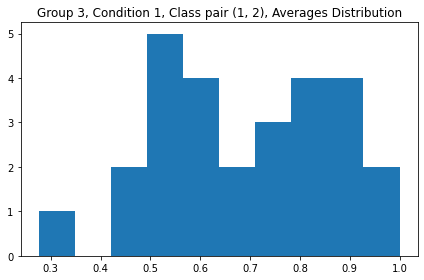

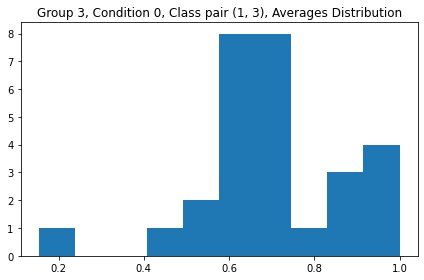

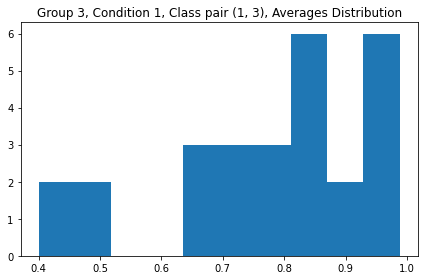

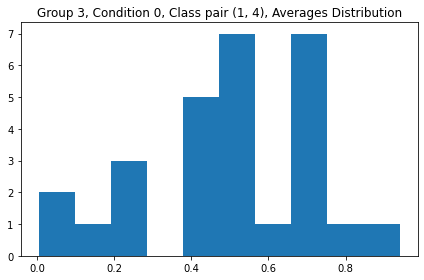

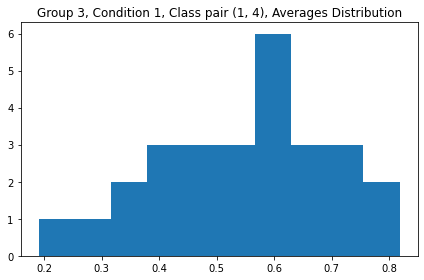

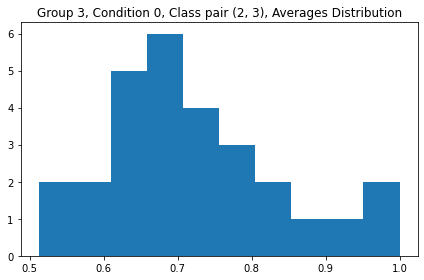

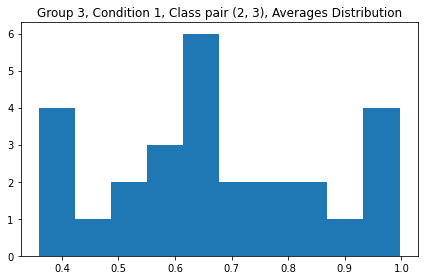

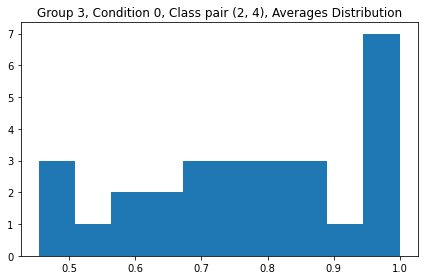

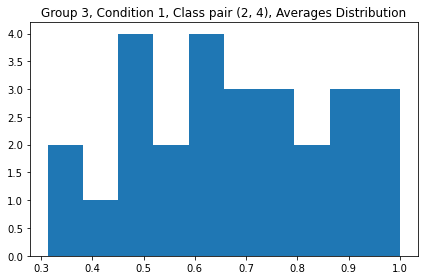

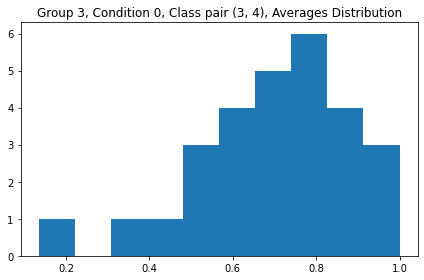

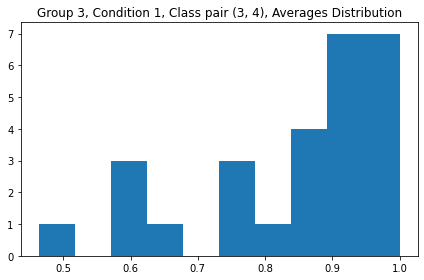

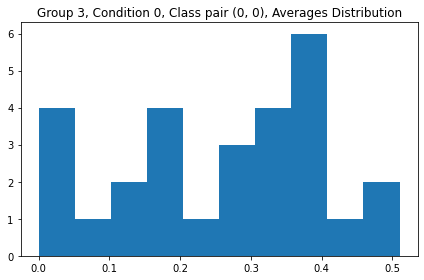

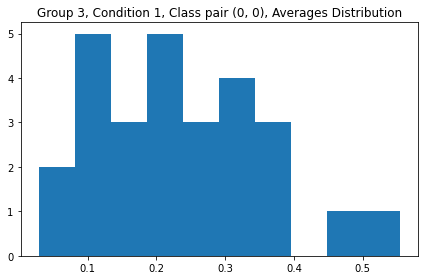

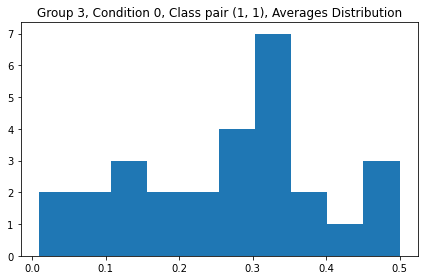

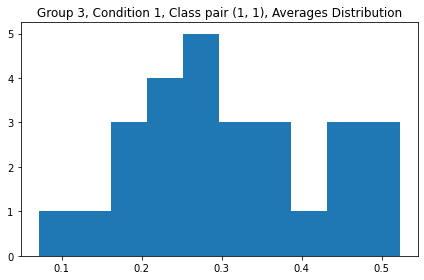

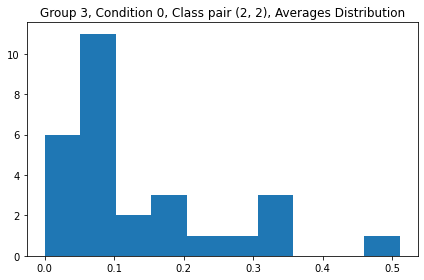

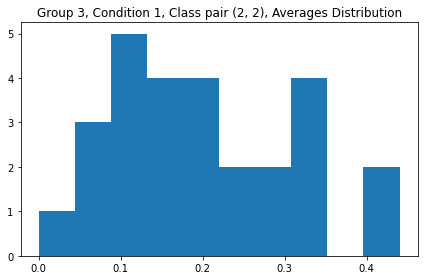

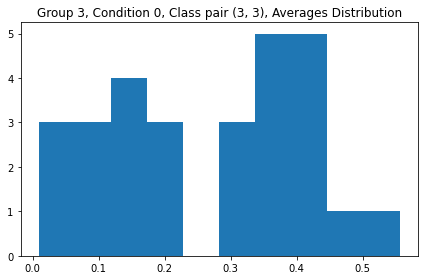

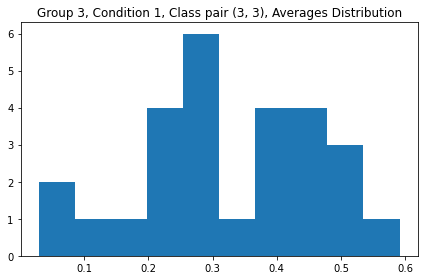

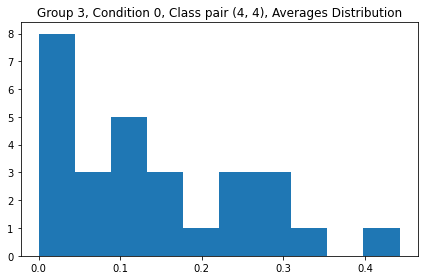

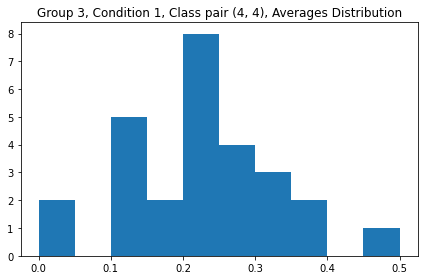

In [59]:
directory_name = 'average_class_distance_distributions'
averaged_groups = {}

for rating_group_idx, rating_group in enumerate(rating_groups):
    
    if rating_group_idx < 2: # ignore first 2 condition groups as we are not interested in these
        continue
    
    group_dict_by_class = {}
    
    for class_group_idx, class_group in enumerate(rating_group):
        # get the average of all the distances for each condition of each class of each group  
        averages_dict_by_condition = {}
        
        for condition_group_idx, condition_group in enumerate(class_group):
            # convert multiple scores for each participant into a single average for them
            participant_averages = []
            
            for part_idx, participant in enumerate(condition_group):

                num_ratings = len(participant)
                average = sum(participant)/len(participant)
                participant_averages.append(average)

            if True:
                plt.hist(participant_averages, bins=10)
                os.makedirs(directory_name, exist_ok=True)
                title ='Group {0}, Condition {2}, Class pair {1}, Averages Distribution'.format(
                    rating_group_idx,
                    class_pairs[class_group_idx],
                    condition_group_idx
                )
                
                plt.title(title)
                plt.tight_layout()
                if save_plot:
                    plt.savefig(directory_name +'/' +title)
                plt.show()
                plt.close() 
            

            averages_dict_by_condition[condition_names[rating_group_idx][condition_group_idx]] = participant_averages
                
        # add this class to the group for this rating groups
        group_dict_by_class[class_pairs[class_group_idx]] = averages_dict_by_condition
        
    averaged_groups[group_names[rating_group_idx]] = group_dict_by_class
    

### (OPTTIONAL) Do Mann-Whitney test between condition groups for accuracy for best performing value of k across the board
This will give the histogram distributions above staatistical significance if it exists. 

In [60]:
from scipy.stats import rankdata, chi2
import math


# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return abs(u1 - u2) / s


def custom_kruskal(conditions_group):
    small_sample_sizes = False
    num_conditions=len(conditions_group)
    d_of_f = num_conditions - 1
    df_table_val = d_of_f - 1
    sample_sizes = []
    sample_means = []
    concatenated_samples = []
    
    for condition in conditions_group:
        sample_size = len(condition)
        sample_sizes.append(sample_size)
        sample_mean = sum(condition)/sample_size
        sample_means.append(sample_mean)
        concatenated_samples.extend(condition)
        
    ranked_samples = rankdata(concatenated_samples)
    sample_ranks = []
    total_participants = 0
    previous_end = 0
    for i in range(num_conditions):
        sample_rank = ranked_samples[previous_end:previous_end+sample_sizes[i]]
        sample_ranks.append(sample_rank)
        total_participants += sample_sizes[i]
        previous_end = previous_end+sample_sizes[i]
    sample_rank_totals = []
    sample_rank_totals_squared = []
    for sample_rank in sample_ranks:
        sample_rank_totals.append(sum(sample_rank))
        sample_rank_totals_squared.append(sum(sample_rank)*sum(sample_rank))
    
    sum_rank_total_squared = 0
    for i in range(len(sample_rank_totals_squared)):
        sum_rank_total_squared += sample_rank_totals_squared[i]/sample_sizes[i]
    
    for sample_size in sample_sizes:
        if sample_size < 5:
            small_sample_sizes = True
            print('small sample size found')
            
    if small_sample_sizes == False:             
        h_value = ( ( 12/(total_participants*(total_participants+1)) * sum_rank_total_squared ) - 3*(total_participants+1) )
        p_value = 1 - chi2.cdf(h_value, d_of_f)
    else:
        raise Exception('write some alternative code here for if your samples are too small!')
    return h_value, p_value


# IF SAMPLES ARE LESS THAN 20, MANUALLY CHECK U VALUE AGAINST THE APPROPRIATE TABLE
def custom_mann_whit(conditions_group): 
    condition1 = np.asarray(conditions_group[0])
    condition2 = np.asarray(conditions_group[1])
    # depending on removed indices, <=30 sample sizes per condition
    sample_a_size = len(condition1)
    sample_b_size = len(condition2)
    sample_a_mean = np.mean(condition1)
    sample_b_mean = np.mean(condition2)


    if type(conditions_group[0])==np.ndarray:
        concatenated_samples = conditions_group[0].tolist()
    else:       
        concatenated_samples = conditions_group[0].copy()
    for value in conditions_group[1]:
        concatenated_samples.append(value)
    ranked_samples = rankdata(concatenated_samples)
    sample_a_ranked = ranked_samples[:sample_a_size]
    sample_b_ranked = ranked_samples[sample_a_size:]
    sample_a_ranked_mean = np.round(np.mean(sample_a_ranked), 2)
    sample_b_ranked_mean = np.round(np.mean(sample_b_ranked), 2)
    
    sample_a_summed_ranks=0
    for i in sample_a_ranked:
        sample_a_summed_ranks += i
    
    u_value = sample_a_size*sample_b_size+(sample_a_size*(sample_a_size + 1)/2) - sample_a_summed_ranks
    u_value_prime = sample_a_size*sample_b_size - u_value
    
    if u_value_prime < u_value:
        u_value = u_value_prime
        
    normal_mean = (sample_a_size*sample_b_size)/2
    normal_std = math.sqrt((sample_a_size*sample_b_size*(sample_a_size + sample_b_size + 1))/12)
    z_value = (u_value - normal_mean)/normal_std
    
    # effect size for interval data?
    
    classic_cohen_d = round(cohend(condition1,condition2), 3) # rounded to 3 decimal points
    
    ordinal_cohen_d = z_value/math.sqrt(sample_a_size*sample_b_size) # uncertain if this is the right way to do it - double-check

#    print(sample_a_mean, sample_b_mean)
    return sample_a_mean, sample_b_mean, abs(z_value), ordinal_cohen_d, u_value, sample_a_size, sample_b_size


from scipy.stats import mannwhitneyu

def multisample_mann_whit(sample_list, sample_names):
    condition_pairs = list(itertools.combinations(range(len(sample_list)), 2))

    sig_results = []
    for i, j in condition_pairs:
        stat, pval = mannwhitneyu(sample_list[i], sample_list[j])

        if pval < sig_thresh:
            result = stat, pval, sample_names[i], sample_names[j]
            print(result)
            sig_results.append(result)
        else:
            print('no diff between samples', sample_names[i], sample_names[j])
    return sig_results
        

def nonpara_multisample_stat_test(samples_list, sig_thresh, sample_names):
    custom_mann_whit_group = []
    annotated_custom_mann_whit_group = np.empty((0,18))
    z_value_threshold = stats.norm.ppf(1 - sig_thresh)
    num_conditions = len(samples_list)
    d_of_f = num_conditions-1

    if num_conditions>2 and num_conditions<10:
        # GET H AND P VALUES
#            take the stats number and look it up on the chi-square table (Tabe E in the book)
#            scipy_kruskal_results = stats.kruskal(conditions_group[0], conditions_group[1], conditions_group[2], conditions_group[3])
#            if kruskal_results[0]>critical_vals_for_05[df_table_val]:
#                if kruskal_results[1]<one_tailed_sig_thresh:
        h_value, p_value = custom_kruskal(samples_list)
        # chisquare function takes h_value and degrees of freedom returns a p value
        if p_value < sig_thresh:
#                reading = ('Rating Group Idx: ', variables_group_idx, 'class_pairs: ', class_pairs[conditions_group_idx], 'kruskal_results: ', h_value, p_value)
##                print(reading)
#                custom_kruskal_group.append(reading)
            # if there is a significant difference, inspect this firuther with mann whitney and adjusted signficance to balance likelihood against multiple comparisons
            condition_pairs = list(itertools.combinations(range(num_conditions), 2))
            # adjust sig levels
            bonferri_corrected_sig_thresh = sig_thresh/d_of_f
            bonferri_corrected_z_threshold = stats.norm.ppf(1 - bonferri_corrected_sig_thresh)
            # go through every combination of conditions
            for con_pair_idx, (condition_a, condition_b) in enumerate(condition_pairs):
                contrast_conditions = (samples_list[condition_a], samples_list[condition_b])
#                 custom_result = custom_mann_whit(contrast_conditions)
#                 print(custom_result)
                mann_whit_results = multisample_mann_whit(contrast_conditions, sample_names)
                
#                 sample_a_mean, sample_b_mean, z_value, ordinal_cohen_d, u_value, sample_a_size, sample_b_size = custom_result
# #                    print('z_value for first condition pair {0} is {1}'.format(condition_pairs[con_pair_idx], z_value))
#                 if z_value < (-bonferri_corrected_z_threshold) or z_value > (bonferri_corrected_z_threshold):
#                     actual_p_val = 1 - stats.norm.cdf(z_value)
#                     print('sample_a_size, sample_b_size', sample_a_size, sample_b_size)  

#                     mean_difference = np.round(abs(sample_a_mean-sample_b_mean), 2)
#                     if sample_a_mean > sample_b_mean:
#                         higher_con_tuple = (condition_a, sample_a_mean)
#                         lower_con_tuple = (condition_b, sample_b_mean)
#                     else:
#                         higher_con_tuple = (condition_b, sample_b_mean)
#                         lower_con_tuple = (condition_a, sample_a_mean)

#                     print('condition_a: ', condition_a,
#                                  'condition_causing_increase: ', higher_con_tuple,
#                                  'condition_causing_decrease: ',lower_con_tuple,
#                                  'Mean increase: ', mean_difference,
#                                  'Effect size: ', ordinal_cohen_d,
#                                  'u-value: ', u_value,
#                                  'z value: ', round(z_value, 4),
#                                  'actual_p_val: ', round(actual_p_val, 4),
#                                  'p value thresh: ', round(bonferri_corrected_sig_thresh, 4)
#                                  )
#                     readings = [condition_a,
#                                  higher_con_tuple,
#                                  lower_con_tuple,
#                                  round(mean_difference, 4),
#                                  ordinal_cohen_d,
#                                  u_value,
#                                  round(z_value, 4),
#                                  round(actual_p_val, 4),
#                                  round(bonferri_corrected_sig_thresh, 4)]
#                     annotated_readings = np.array(['condition_a:1 ', condition_a,
#                                                    'condition_causing_increase:3 ', higher_con_tuple,
#                                                    'condition_causing_decrease:5 ',lower_con_tuple,
#                                                    'Mean increase:7 ', mean_difference,
#                                                    'Effect size:9 ', ordinal_cohen_d,
#                                                    'u-value:11 ', u_value,
#                                                    'z value:13 ', round(z_value, 4),
#                                                    'actual_p_val:15 ', round(actual_p_val, 4),
#                                                    'p value thresh:17 ', round(bonferri_corrected_sig_thresh, 4)])
#                     custom_mann_whit_group.append(readings)
#                     annotated_readings = annotated_readings.reshape(-1, len(annotated_readings))
#                     annotated_custom_mann_whit_group = np.append(annotated_custom_mann_whit_group, annotated_readings, axis=0)

#     elif num_conditions==2:
# #                print(contrast_conditions)
#         # same contrast condition info comes in THE FIRST TIME, but is calculated differently in cmw2 than in cmw2
#         sample_a_mean, sample_b_mean, z_value, ordinal_cohen_d, u_value, sample_a_size, sample_b_size = custom_mann_whit(conditions_group)
#         if z_value < (-z_value_threshold) or z_value > (z_value_threshold):
#             actual_p_val = 1 - stats.norm.cdf(z_value)
#             print('sample_a_size, sample_b_size', sample_a_size, sample_b_size)  

#             mean_difference = abs(sample_a_mean-sample_b_mean)
#             if sample_a_mean > sample_b_mean:
#                 higher_con_tuple = (0, sample_a_mean)
#                 lower_con_tuple = (1, sample_b_mean)
#             else:
#                 higher_con_tuple = (1, sample_b_mean)
#                 lower_con_tuple = (0, sample_a_mean)

#             print('condition_a: ', condition_a,
#                          'condition_causing_increase: ', higher_con_tuple,
#                          'condition_causing_decrease: ',lower_con_tuple,
#                          'Mean increase: ', mean_difference,
#                          'Effect size: ', ordinal_cohen_d,
#                          'u-value: ', u_value,
#                          'z value: ', round(z_value, 4),
#                          'actual_p_val: ', round(actual_p_val, 4),
#                          'p value thresh: ', round(sig_thresh, 4),
#                          )   
#             readings = [variables_group_idx,
#                         higher_con_tuple,
#                          lower_con_tuple,
#                          round(mean_difference, 4),
#                          ordinal_cohen_d,
#                          u_value,
#                          round(z_value, 4),
#                          round(actual_p_val, 4),
#                          round(sig_thresh, 4)]
#             annotated_readings = np.array(['condition_a:1 ', condition_a,
#                                            'condition_causing_increase:5 ', higher_con_tuple,
#                                            'condition_causing_decrease:7 ',lower_con_tuple,
#                                            'Mean increase:9 ', mean_difference,
#                                            'Effect size:11 ', ordinal_cohen_d,
#                                            'u-value: ', u_value,
#                                            'z value:13 ', round(z_value, 4),
#                                            'actual_p_val:15 ', round(actual_p_val, 4),
#                                            'p value thresh:17 ', round(sig_thresh, 4)])
#             custom_mann_whit_group.append(readings)
#             annotated_readings = annotated_readings.reshape(-1, len(annotated_readings))
#             annotated_custom_mann_whit_group = np.append(annotated_custom_mann_whit_group, annotated_readings, axis=0)
    
    return annotated_custom_mann_whit_group, custom_mann_whit_group

LOWS 



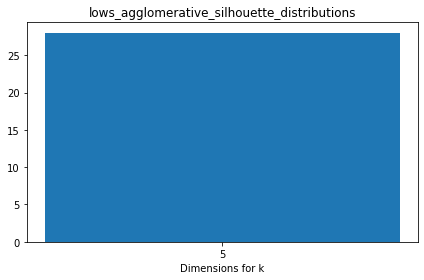

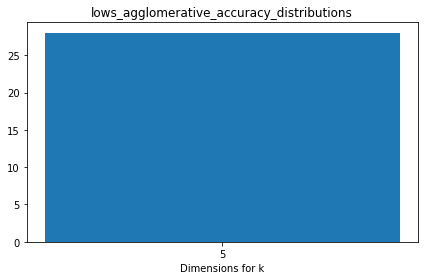

HIGHS 



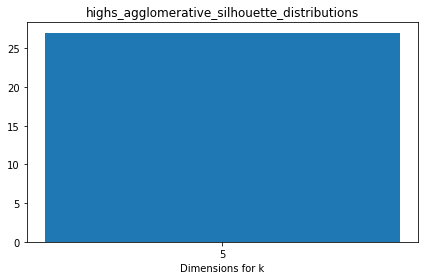

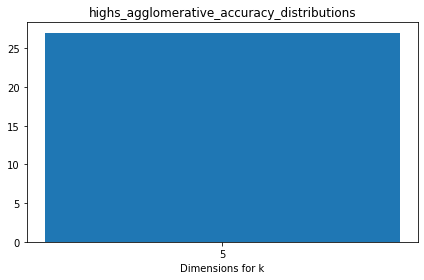

MALE 



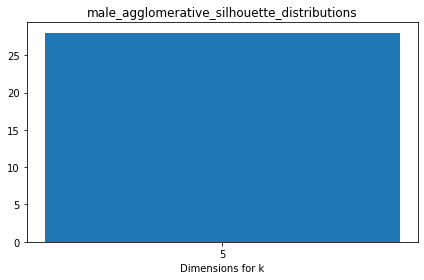

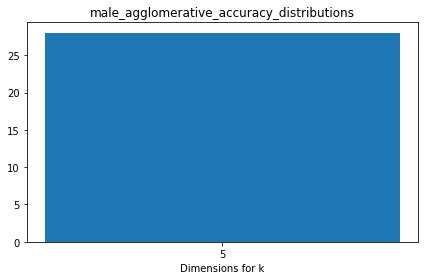

FEMALE 



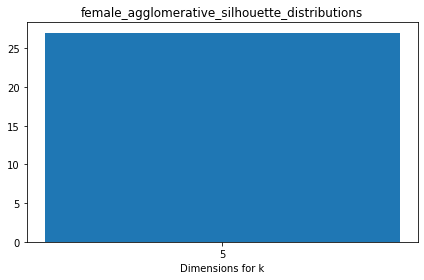

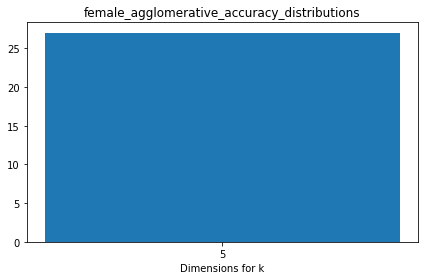

In [61]:
# agg_sil_score, best_agg_sil = find_best_k_values(h5=h5_ram,
#                                  indices=indices_list,
#                                  condition_name=condition_name,
#                                  k=5,
#                                  cluster_algorithm='agglomerative',
#                                  score_type='silhouette',
#                                  show_plot=plots)


all_conditional_scores = []
for i in range(2,4): # only using register and gender groupings
    cond_group_indices = indices_grouped_by_condition_groups[i]
    for j in range(len(cond_group_indices)):
        cond_indices = cond_group_indices[j]
        cond_name = condition_names[i][j]
        scores = get_scores_for_cond_indices(h5_ram, cond_indices, cond_name, k=5, plots=False)
        all_conditional_scores.append(scores)

all_cond_accs = []
for conditional_scores in all_conditional_scores:
    _, _, agg_acc_score, _ = conditional_scores
    all_cond_accs.append(agg_acc_score)

In [62]:
music_conds = [[],[],[]]

for idx, prof_arr in enumerate(profile_array):
    music_conds[int(prof_arr[2])].append(idx)  

In [63]:
sig_thresh = 0.05
# two_tailed_sig_thresh = sig_thresh/2
music_cond_names = ['nonmus', 'mus', 'vocal']
annotated_results, results = nonpara_multisample_stat_test(music_conds, sig_thresh, music_cond_names)

no diff between samples nonmus mus
no diff between samples nonmus mus
(273.0, 0.013763229222042322, 'nonmus', 'mus')


# Generate MDS plots

In [64]:
print(averaged_groups.keys())
print(averaged_groups['intra_register_ratings'].keys())
print(averaged_groups['intra_register_ratings'][(0, 1)].keys())
print(averaged_groups['intra_register_ratings'][(0, 1)]['lows'])

dict_keys(['intra_register_ratings', 'intra_gender_ratings'])
dict_keys([(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4)])
dict_keys(['lows', 'highs'])
[0.4722222222222221, 0.74, 0.5666666666666667, 0.23000000000000004, 0.6244444444444446, 0.6716666666666667, 0.5788888888888888, 0.7977777777777778, 0.7733333333333333, 0.8044444444444444, 0.4283333333333333, 0.3111111111111111, 0.7277777777777779, 0.6644444444444445, 0.5966666666666667, 0.6916666666666668, 0.5077777777777778, 0.635, 0.5444444444444445, 0.8066666666666666, 0.8344444444444443, 0.44777777777777783, 0.4088888888888889, 0.5455555555555556, 0.6633333333333333, 0.3022222222222222, 0.36000000000000004, 0.5433333333333333]


### MDS for register conditions

In [65]:
def summarize_cond_grouped_ratings_mds(
    cond_grouped_ratings,
    statistical_summary,
    condition_labels,
    class_pairs,
    mds_dim=2,
    show_plot=True
):
    classpair_groups = []
    mds_groups = []

    for class_pair_key in cond_grouped_ratings.keys():
    #     print('class_pair_key', class_pair_key)
        cond_group = []

        # key_2s relate to the class-pair variable names ((0,1), (0,2) etc.)
        for cond_specific_key in cond_grouped_ratings[class_pair_key].keys():
#             print('cond_specific_key', cond_specific_key)

            # key_3 relates to which condition specifically can be accessed with it
            avg_vals_list = cond_grouped_ratings[class_pair_key][cond_specific_key]
            if statistical_summary == 'mean':
                value_summary = np.mean(avg_vals_list)
            elif statistical_summary == 'median':
                value_summary = np.median(avg_vals_list)
            else:
                NotImplementedError
            cond_group.append(value_summary)
        classpair_groups.append(np.asarray(cond_group))

    classpair_specific_group_array = np.asarray(classpair_groups)
    # print('classpair_specific_group_array,shape', classpair_specific_group_array.shape)

    for condition_int in range(classpair_specific_group_array.shape[1]):
        class_dissim_matrix = np.empty((5,5))
        conditioned_variables_array = classpair_specific_group_array[:,condition_int]
        for classpair_idx in range(len(class_pairs)):
            coord_1, coord_2 = class_pairs[classpair_idx]
            class_dissim_matrix[coord_1, coord_2] = conditioned_variables_array[classpair_idx]

        for i in range(5):
            for j in range(5):
                class_dissim_matrix[j,i] = class_dissim_matrix[i,j]

        title = condition_labels[condition_int]
        mds_coords = mds_from_dissim_matrix(class_dissim_matrix, label_list, mds_dim, show_plot=show_plot, title=title)
        mds_groups.append(mds_coords)
        
    return np.asarray(classpair_groups), np.asarray(mds_groups)

WITH MEDIANS
registers


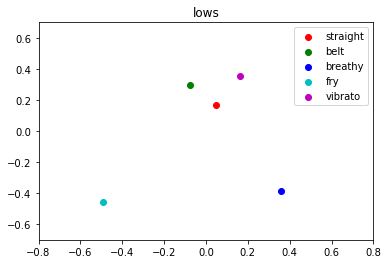

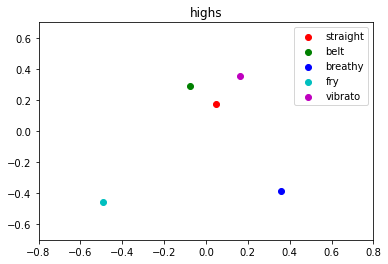

genders


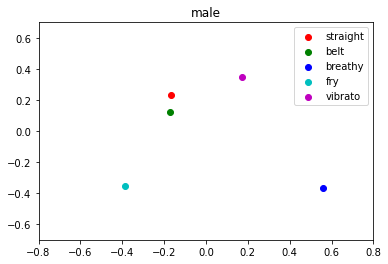

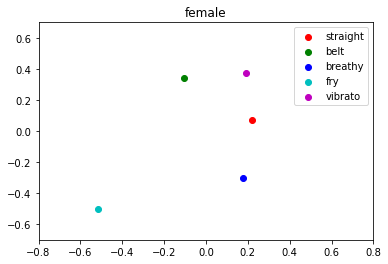

WITH MEANS
registers


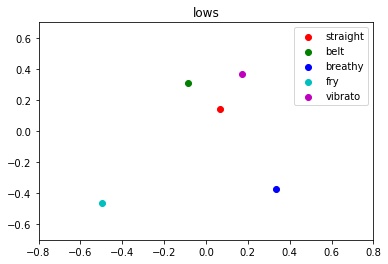

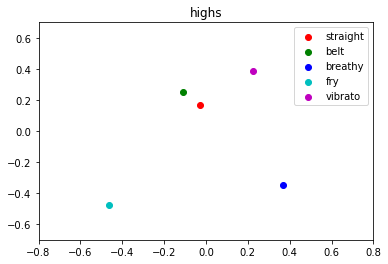

genders


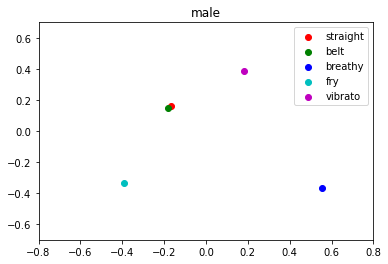

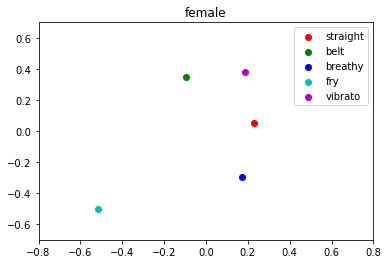

In [67]:
print('WITH MEDIANS')
print('registers')
register_classpair, register_mds = summarize_cond_grouped_ratings_mds(averaged_groups['intra_register_ratings'],
                                                        'median',
                                                        register_cond_names,
                                                        class_pairs,
                                                        mds_dim=2,
                                                        show_plot=True)
print('genders')
register_classpair, register_mds = summarize_cond_grouped_ratings_mds(averaged_groups['intra_gender_ratings'],
                                                        'median',
                                                        gender_cond_names,
                                                        class_pairs,
                                                        mds_dim=2,
                                                        show_plot=True)
print('WITH MEANS')
print('registers')
register_classpair, register_mds = summarize_cond_grouped_ratings_mds(averaged_groups['intra_register_ratings'],
                                                        'mean',
                                                        register_cond_names,
                                                        class_pairs,
                                                        mds_dim=2,
                                                        show_plot=True)
print('genders')
register_classpair, register_mds = summarize_cond_grouped_ratings_mds(averaged_groups['intra_gender_ratings'],
                                                        'mean',
                                                        gender_cond_names,
                                                        class_pairs,
                                                        mds_dim=2,
                                                        show_plot=True)